In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0


In [3]:
import pathlib
Dataset_Path = 'data_path/'
data_dir = pathlib.Path(Dataset_Path)

In [4]:
import os
import numpy as np
import glob
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

def GetFileName(root,root_len):
    filenames = glob.glob(os.path.join(root, '*_image1.png'))
    #check if is nan
    label = pd.read_csv(root+ "/train.csv")
    label = label.dropna()
    label = label['id']
    label = label.array
    #delete nan hand
    count = len(filenames) - 1
    while (count >= 0):
        if (filenames[count][-(len(filenames[count]))+root_len+1:-11] not in label):
            filenames.remove(filenames[count])
        count = count - 1
    return filenames

def replication (paths,root_len):
    label = pd.read_csv('data_path/train.csv',index_col='id')
    orilen = len(paths)
    for i in range(orilen):
        if label.loc[paths[i][-(len(paths[i]))+root_len+1:-11]][0] == 1:
            paths.append(paths[i])
    return paths

class GetDataSet(Dataset):
    def __init__(self,file,file_paths,train=True):
        self.file_paths = file_paths #file names of images
        self.train = train
        self.resize = transforms.Resize((512,512))
        if (self.train):
            self.transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(180, expand=True),
                transforms.Resize((512,512)),
                transforms.RandomEqualize(1),
                transforms.ToTensor()
                ])
        else:
            self.transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomEqualize(1),
                transforms.ToTensor()
                ])
        self.num_samples = len(self.file_paths)
        self.filenames = glob.glob(os.path.join(os.path.join('data_path/',file), "*.png"))
        self.label = pd.read_csv('data_path/train.csv',index_col='id')
        self.train_folder = 'data_path/train'

    def __getitem__(self,idx):
        file_path = self.file_paths[idx]
        img1 = torchvision.io.read_image(file_path,torchvision.io.ImageReadMode(1))
        img1 = self.transforms(img1)
        img1 = self.padding(img1)
        check = 0
        if(file_path[-len(file_path):-5]+'2.png' in self.filenames):
            img2 = torchvision.io.read_image(file_path[-len(file_path):-5]+'2.png',torchvision.io.ImageReadMode(1))
            img2 = self.transforms(img2)
            img2 = self.padding(img2)
            check = check + 1
        if(file_path[-len(file_path):-5]+'3.png' in self.filenames):
            img3 = torchvision.io.read_image(file_path[-len(file_path):-5]+'3.png',torchvision.io.ImageReadMode(1))
            img3 = self.transforms(img3)
            img3 = self.padding(img3)
            check = check + 1
        if(file_path[-len(file_path):-5]+'4.png' in self.filenames):
            img4 = torchvision.io.read_image(file_path[-len(file_path):-5]+'4.png',torchvision.io.ImageReadMode(1))
            img4 = self.transforms(img4)
            img4 = self.padding(img4)
            check = check + 1
        if (check == 3):img = torch.cat((img1,img2,img3,img4))
        elif (check == 2):img = torch.cat((img1,img2,img3,img1))
        elif (check == 1):img = torch.cat((img1,img2,img1,img1))
        else:img = torch.cat((img1,img1,img1,img1))
        
        if (self.train):
            return img,self.label.loc[file_path[-len(file_path)+len(self.train_folder)+1:-11]][0]
        else:
            return img
        
    def __len__(self):
        return self.num_samples

    def padding(self,img):
        h = img.size()[0]
        w = img.size()[1]
        if w != 512 or h != 512:
            if h > w:
                img = F.pad(img,((h-w)/2),((h-w)/2),0,0)
            elif w < h:
                img = F.pad(img,(0,0,(w-h)/2),((w-h)/2),0,0)
            img = self.resize(img)
        return img



/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
train_folder = 'data_path/train'
train_paths = GetFileName('data_path/train',len(train_folder))
train_paths = replication(train_paths,len(train_folder))
test_paths = glob.glob(os.path.join('data_path/test', '*_image1.png'))
train_dataset = GetDataSet('train',train_paths,train = True)
test_dataset = GetDataSet('test',test_paths,train = False)

In [6]:
print(len(train_dataset))
print(len(test_dataset))

3525
500


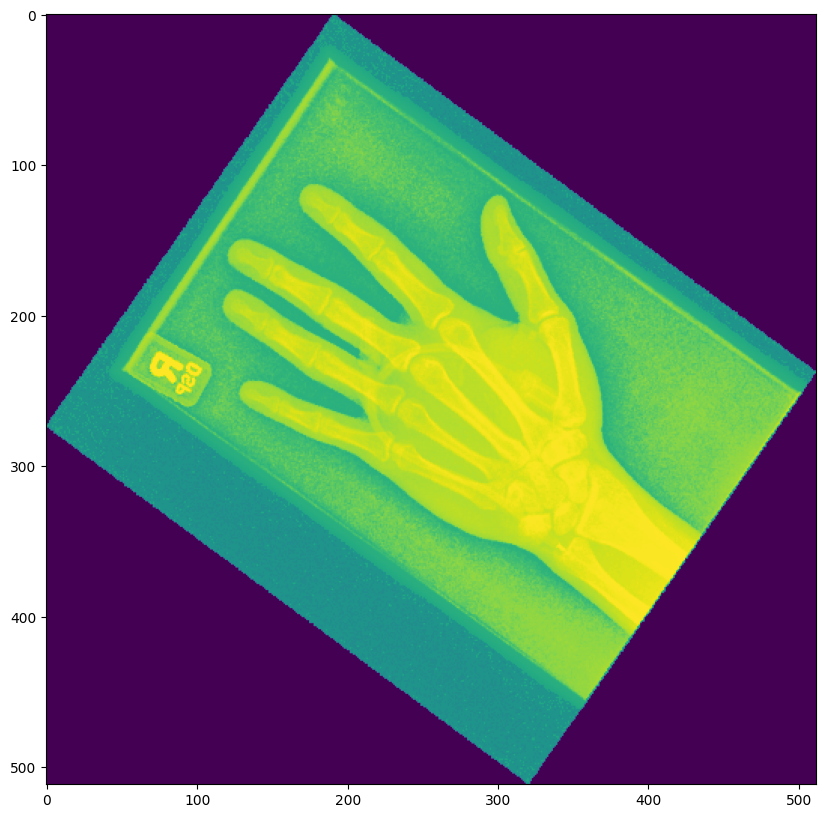

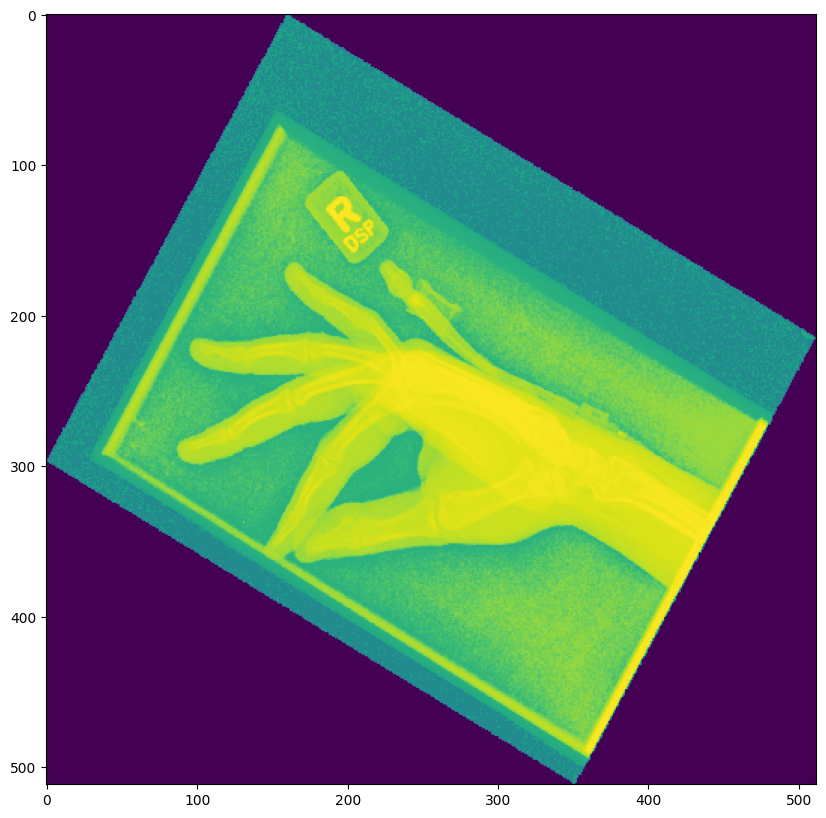

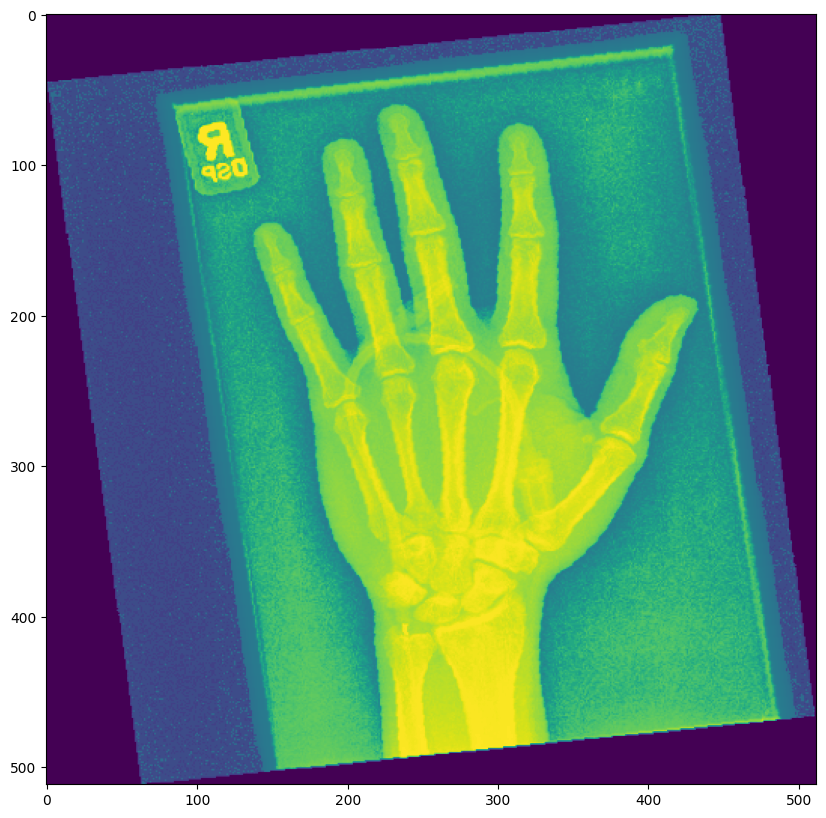

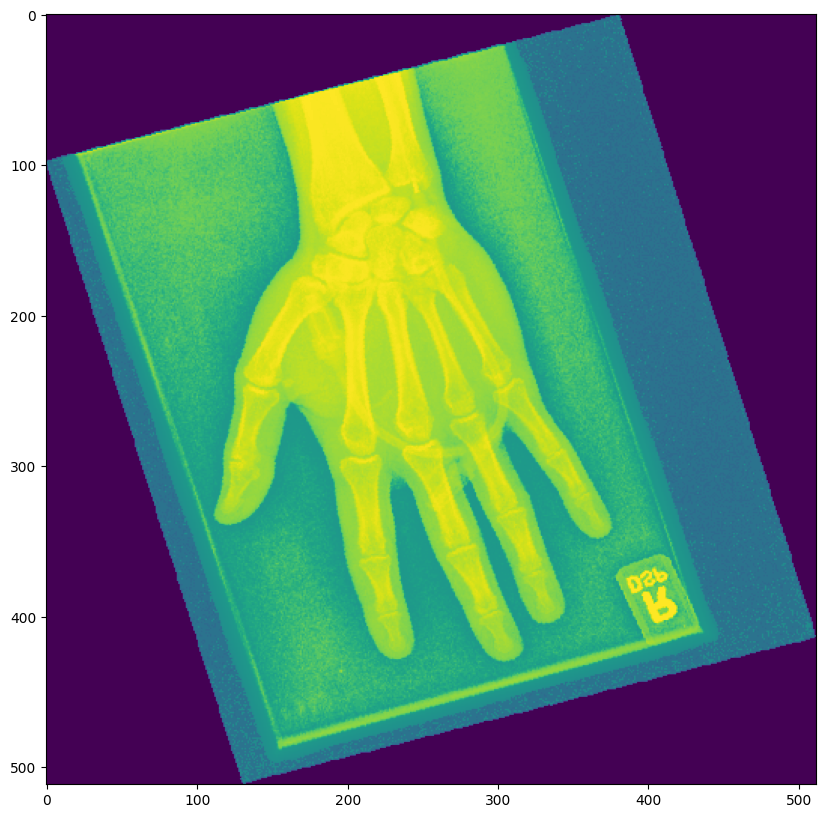

In [7]:
#check dataset
#the first index stands for the index of the images
#the second index implies it is the image not the label
#the third is the index of the channel
img = train_dataset[1][0][0] 
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

img = train_dataset[1][0][1]
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

img = train_dataset[1][0][2]
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

img = train_dataset[1][0][3]
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [8]:
#construct data loader
import torch.utils.data as data
batch_size = 15
VAL_RATIO = 0.2
percent = int(len(train_dataset) * (1 - VAL_RATIO))
train_set, valid_set = data.random_split(train_dataset, [percent, len(train_dataset)-percent])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [9]:
"""
#get pretrained model using torchvision.models as models library
from torch.autograd import Variable
model = torch.hub.load('pytorch/vision:v0.14.0', 'resnet50', weights=True)
torch.hub.list('pytorch/vision:v0.14.0', force_reload=False, skip_validation=False, trust_repo=None)
#turn off training for their parameters
for param in model.parameters():
    param.requires_grad = True

#change the number of input channels to 4 
weight1 = model.conv1.weight.clone()
new_first_layer  = nn.Conv2d(4, model.conv1.out_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).requires_grad_()
new_first_layer.weight[:,:3,:,:].data[...] =  Variable(weight1, requires_grad=True)
model.conv1 = new_first_layer

#check model weight
print(model.conv1.weight.size())
"""

"\n#get pretrained model using torchvision.models as models library\nfrom torch.autograd import Variable\nmodel = torch.hub.load('pytorch/vision:v0.14.0', 'resnet50', weights=True)\ntorch.hub.list('pytorch/vision:v0.14.0', force_reload=False, skip_validation=False, trust_repo=None)\n#turn off training for their parameters\nfor param in model.parameters():\n    param.requires_grad = True\n\n#change the number of input channels to 4 \nweight1 = model.conv1.weight.clone()\nnew_first_layer  = nn.Conv2d(4, model.conv1.out_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).requires_grad_()\nnew_first_layer.weight[:,:3,:,:].data[...] =  Variable(weight1, requires_grad=True)\nmodel.conv1 = new_first_layer\n\n#check model weight\nprint(model.conv1.weight.size())\n"

In [10]:
#get pretrained model using torchvision.models as models library
from torch.autograd import Variable
#model = torch.hub.load('pytorch/vision:v0.14.0', 'resnet50', pretrained=True)
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
#turn off training for their parameters
for param in model.parameters():
    param.requires_grad = True

#change the number of input channels to 4 
weight1 = model.conv1.weight.clone()
new_first_layer  = nn.Conv2d(4, model.conv1.out_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).requires_grad_()
new_first_layer.weight[:,:3,:,:].data[...] =  Variable(weight1, requires_grad=True)
model.conv1 = new_first_layer

#check model weight
print(model.conv1.weight.size())


Using cache found in /home/u3675487/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/u3675487/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


torch.Size([64, 4, 7, 7])


In [11]:
#create new classifier for model using torch.nn as nn library
classifier_input = model.fc.in_features
num_labels = 2 #PUT IN THE NUMBER OF LABELS IN YOUR DATA
classifier = nn.Sequential(nn.Linear(classifier_input, 512),
                           nn.ReLU(),
                           nn.Linear(512, 64),
                           nn.ReLU(),
                           nn.Linear(64, num_labels),
                           nn.LogSoftmax(dim=1))
#replace default classifier with new classifier
model.fc = classifier

In [12]:
# Find the device available to use using torch library
device = torch.device("cuda")
#device = "cpu"
# Move model to the device specified above
model.to(device)

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [13]:
#set the error function using torch.nn as nn library
criterion = nn.NLLLoss()
#set the optimizer function using torch.optim as optim library
optimizer = optim.Adam(model.parameters(),lr = 0.0003)

1 / 188 Loss =  tensor(0.6647, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.6724, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.7311, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.6997, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.6726, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.6695, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.6932, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.6701, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.6901, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.6526, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.7054, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.6781, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.6393, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

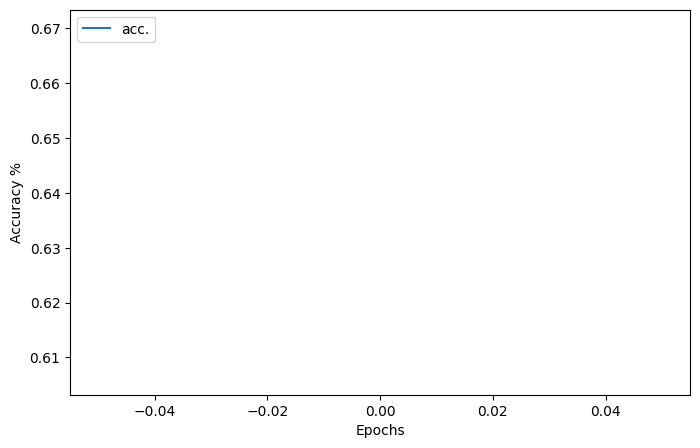

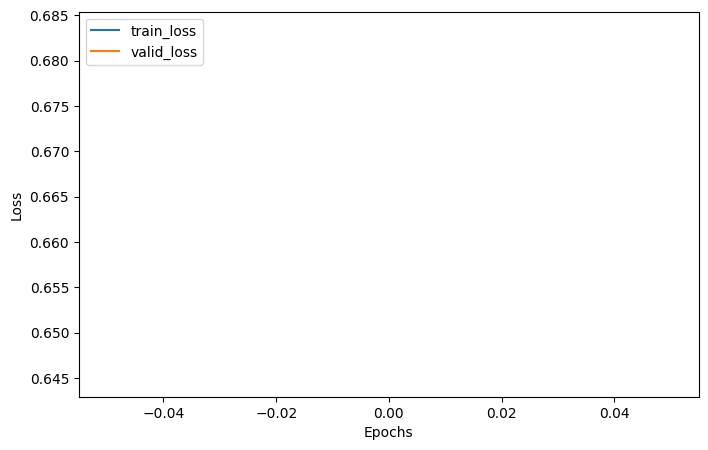

1 / 188 Loss =  tensor(0.4793, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.5314, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.6290, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.4609, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.5572, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.5188, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.7798, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.4514, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4396, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.5248, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.5088, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.6791, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5912, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

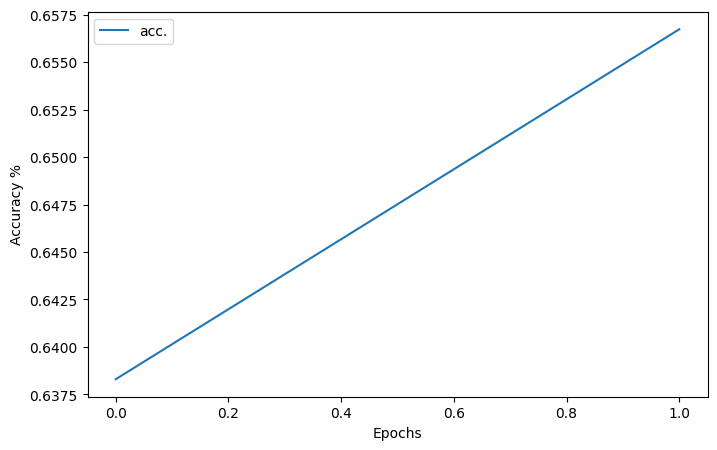

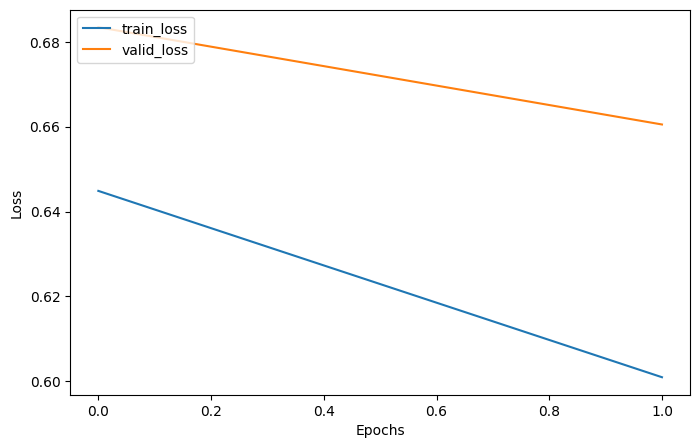

1 / 188 Loss =  tensor(0.5319, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.7917, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.6746, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.6641, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.6014, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.6727, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.4983, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.5452, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.5313, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.5765, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.5921, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4198, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.6387, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

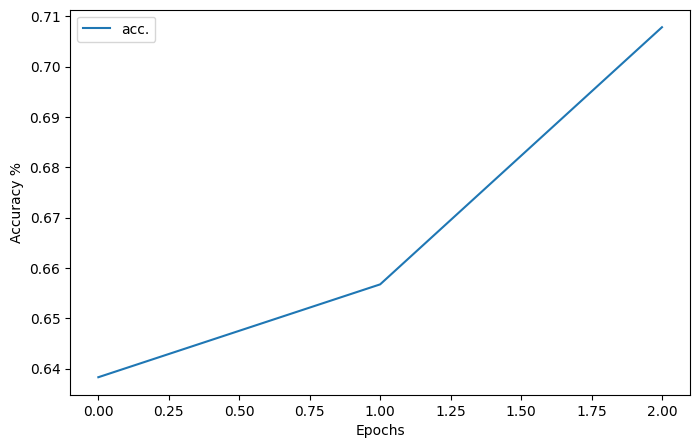

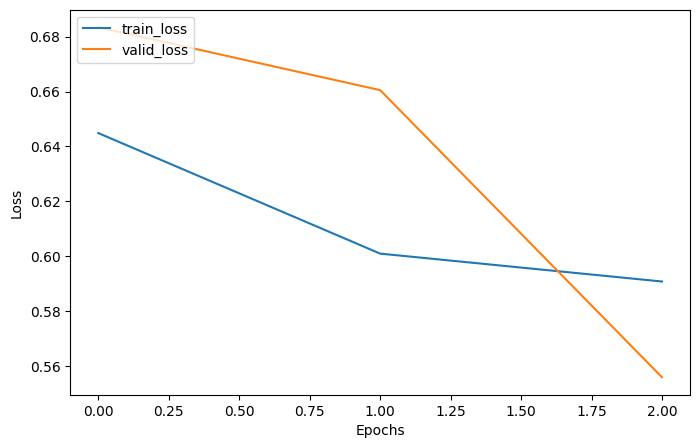

1 / 188 Loss =  tensor(0.5663, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.5231, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.4937, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.6478, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.6640, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4514, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.4556, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.6611, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.5901, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4811, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.5461, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.5226, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.6337, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

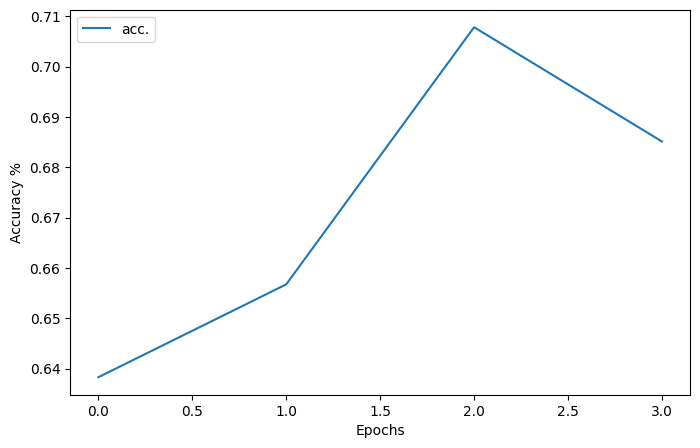

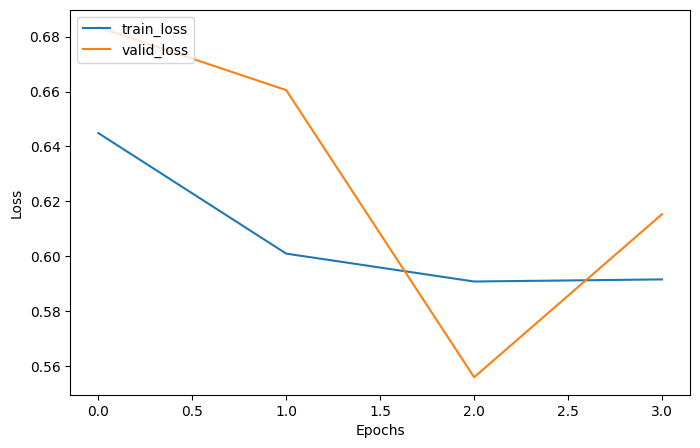

1 / 188 Loss =  tensor(0.5224, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.5889, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.5114, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.6198, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.7654, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.5752, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.6559, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.6130, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.8122, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.5643, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.4777, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.7090, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.9254, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

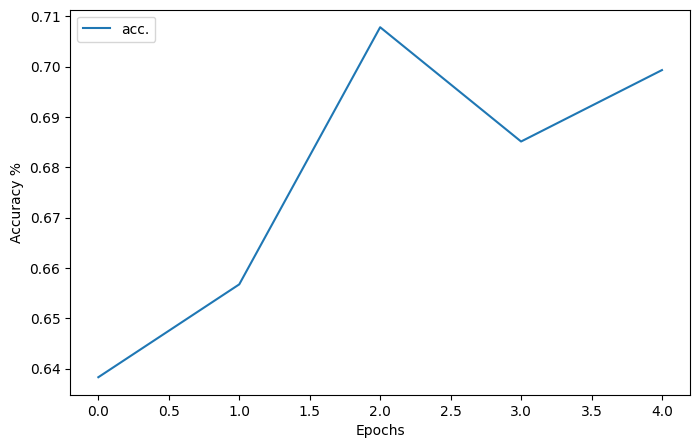

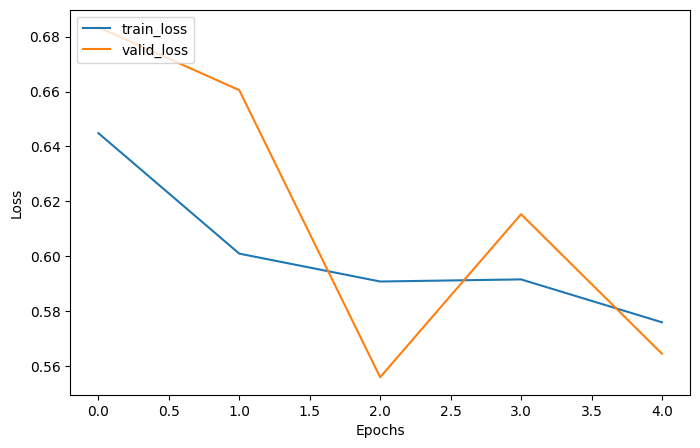

1 / 188 Loss =  tensor(0.5427, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.8991, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.5460, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.5232, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.5589, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.8331, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.4553, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.4254, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.6151, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4895, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.4806, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4622, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5993, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

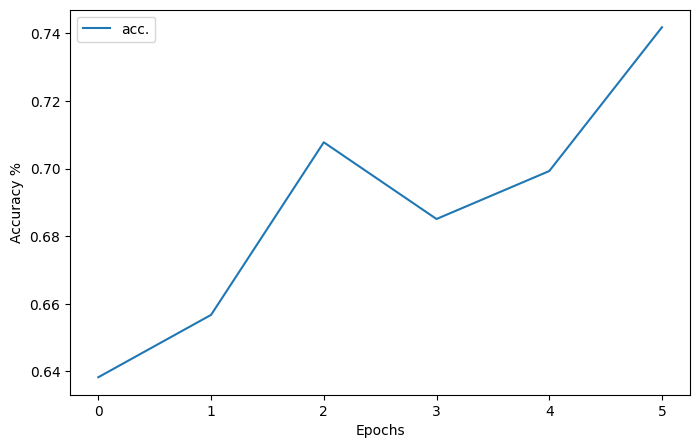

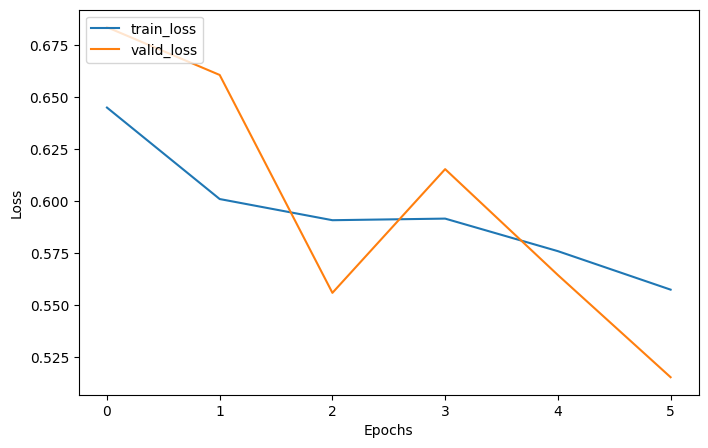

1 / 188 Loss =  tensor(0.5287, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.6194, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.4433, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.4200, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.6525, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4347, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.6600, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.3234, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.3641, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4211, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.4072, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.6096, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.4595, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

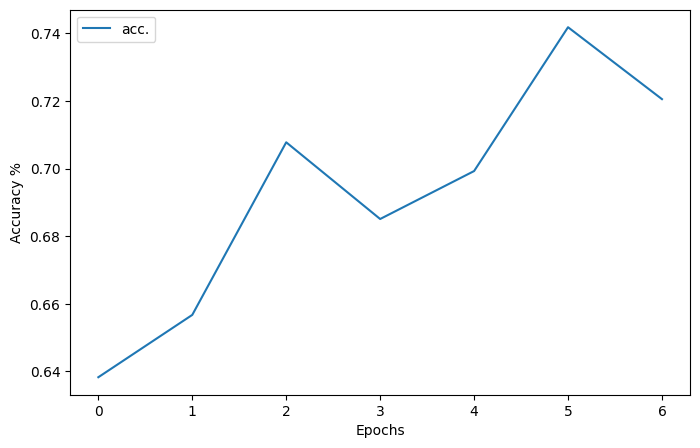

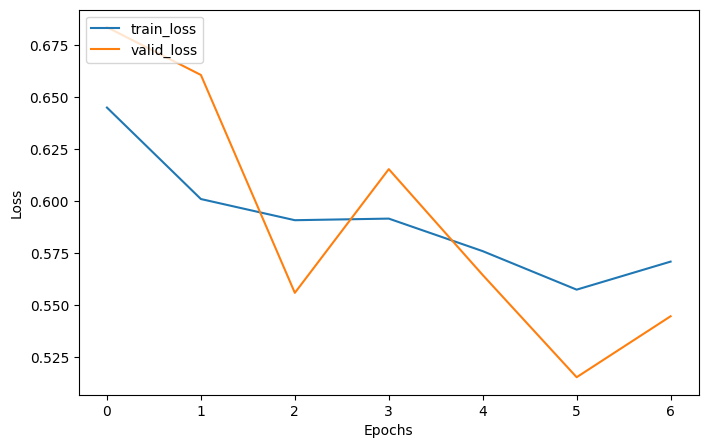

1 / 188 Loss =  tensor(0.5466, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4865, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.4314, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.5968, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.5270, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.5338, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.3663, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.6818, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.3997, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4198, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.5131, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4583, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.4856, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

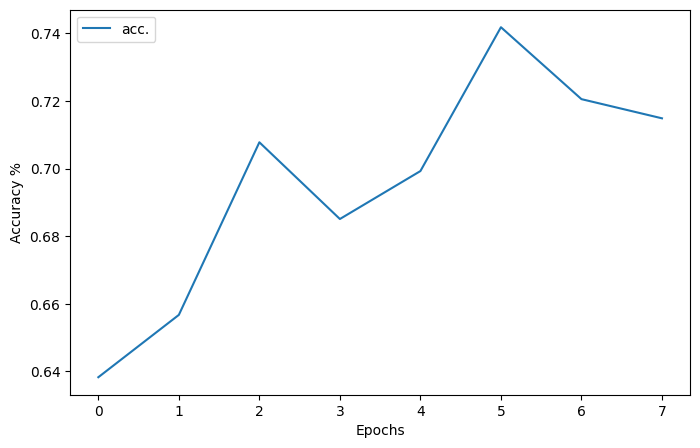

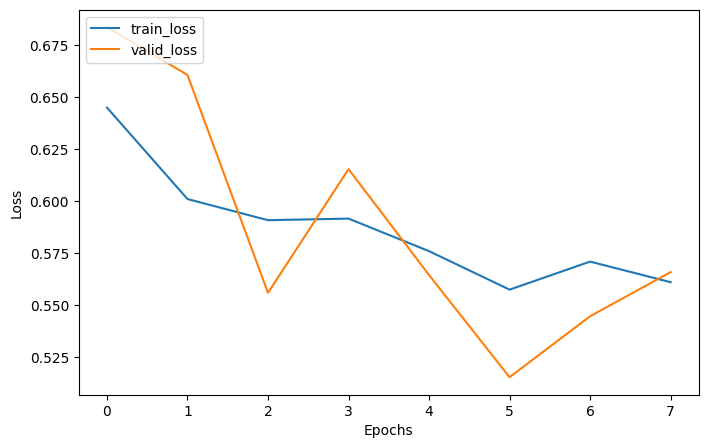

1 / 188 Loss =  tensor(0.5895, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.5290, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.4230, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.5298, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.5397, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4975, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.7810, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.6095, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.5905, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4494, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.6615, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.7318, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5556, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

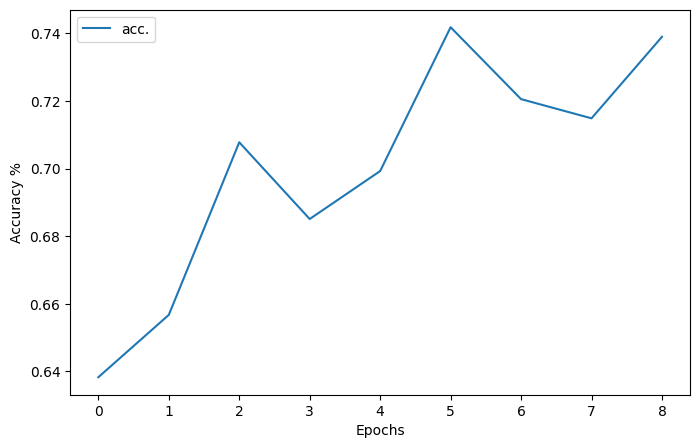

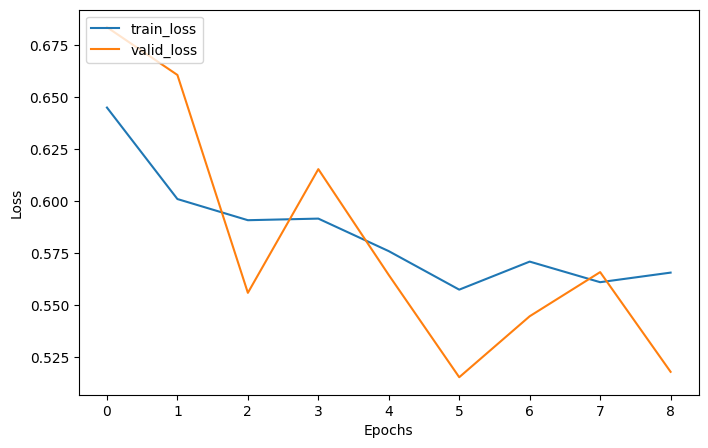

1 / 188 Loss =  tensor(0.3788, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.3623, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.3591, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.5126, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.5609, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.5715, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.4908, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.6716, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4236, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4039, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.6924, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.5152, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5152, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

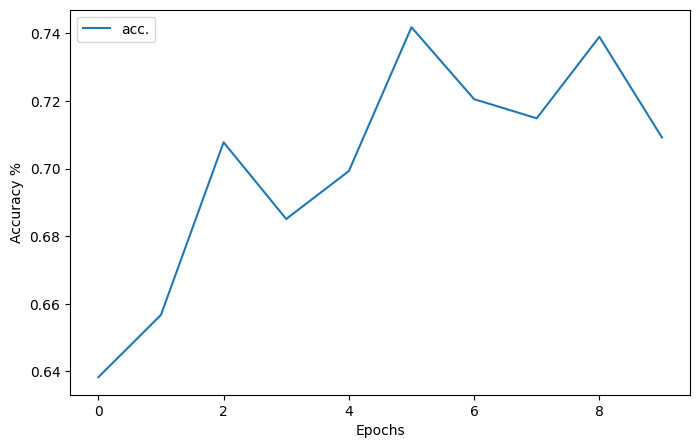

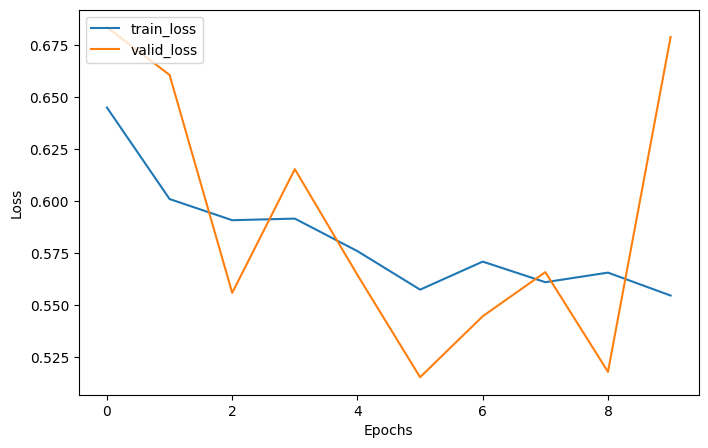

1 / 188 Loss =  tensor(0.8847, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.3529, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.5045, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.3308, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.5566, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.5538, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.7679, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.3453, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4057, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.5605, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.7298, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.6206, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.3706, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

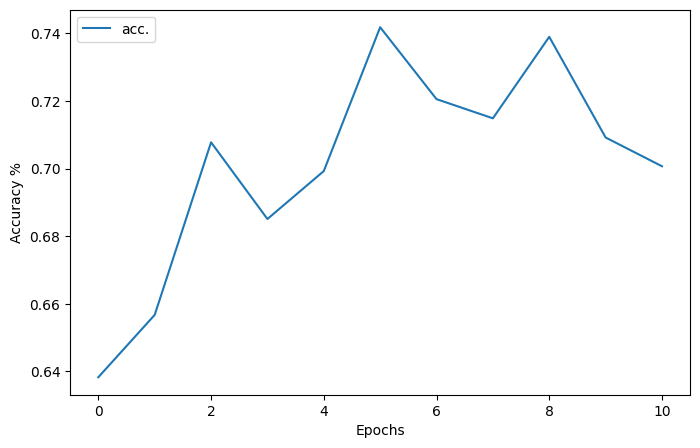

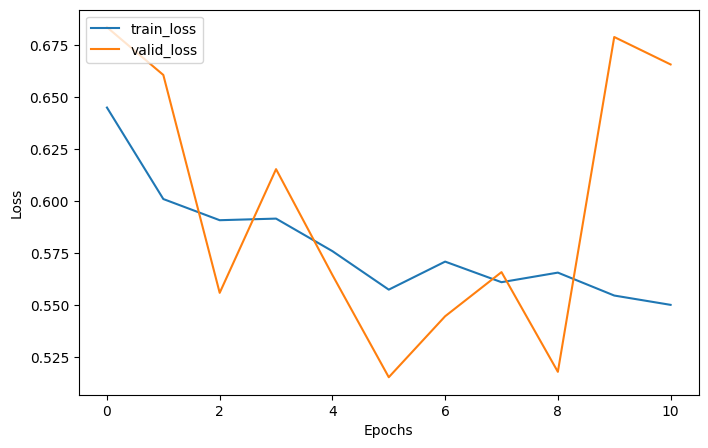

1 / 188 Loss =  tensor(0.8456, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4695, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.4518, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.4989, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.5232, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4542, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.5261, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.5626, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4790, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.5975, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.6786, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.5167, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5717, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

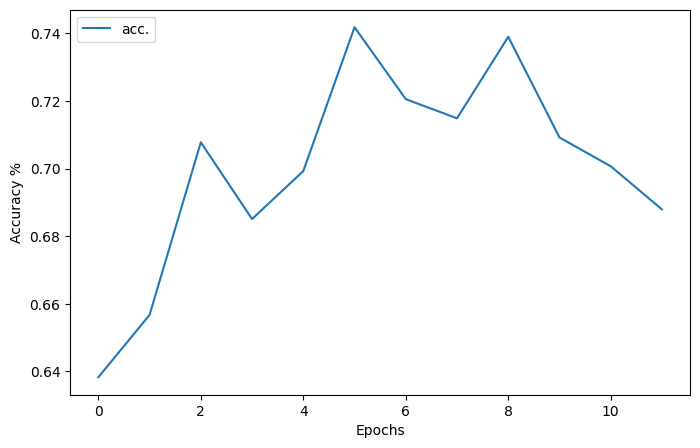

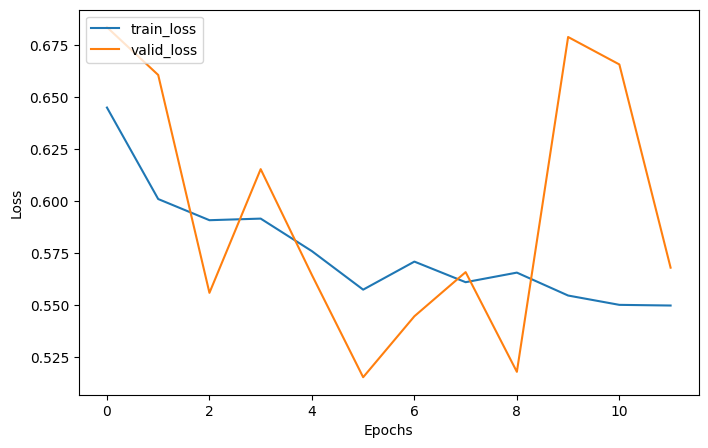

1 / 188 Loss =  tensor(0.4425, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.3944, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.5052, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.4205, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.6641, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4586, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.5383, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.4524, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4983, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4487, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.7409, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.3642, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.4818, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

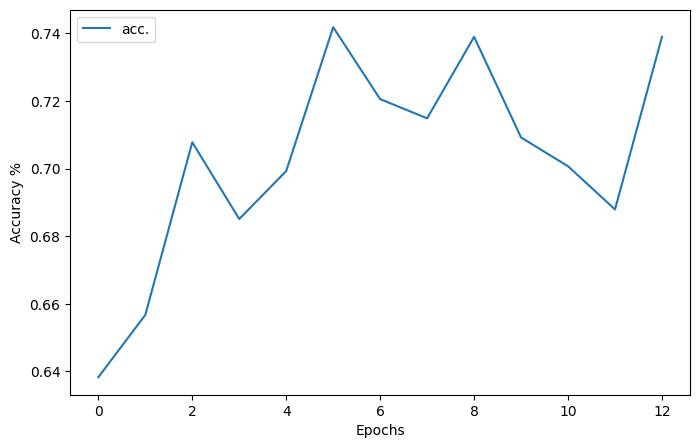

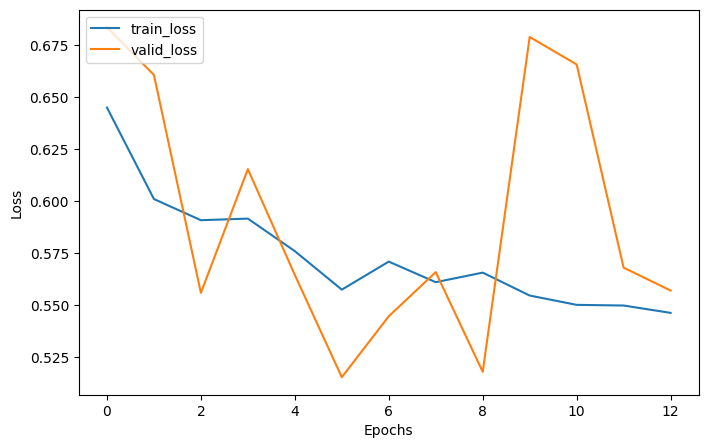

1 / 188 Loss =  tensor(0.4406, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.5397, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.5442, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.4061, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.4870, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4462, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.6234, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.4106, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4856, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4542, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.4573, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.3956, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.4977, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

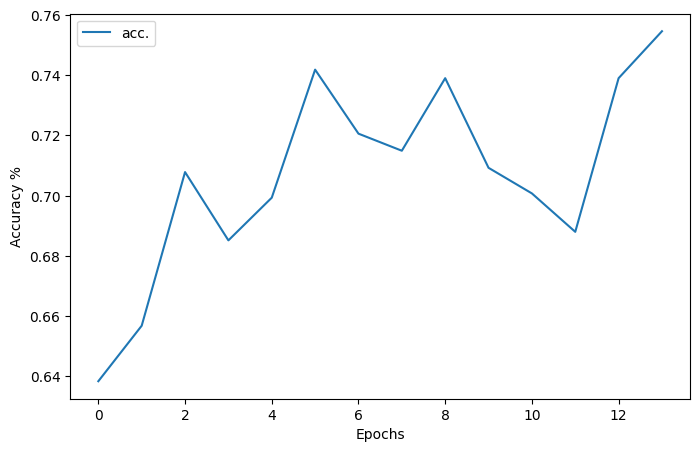

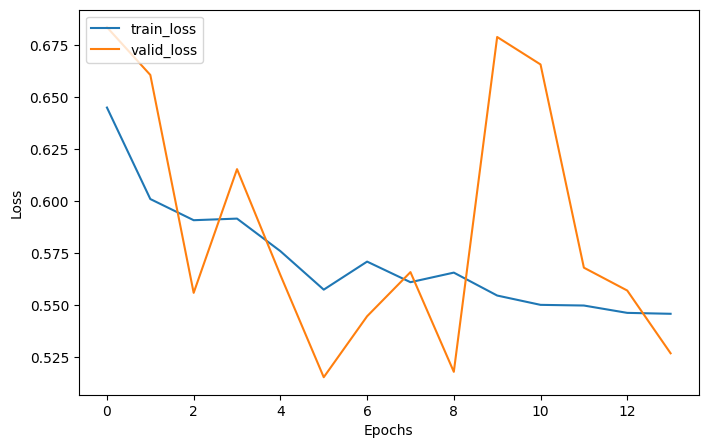

1 / 188 Loss =  tensor(0.6000, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.5763, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.3050, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.5033, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.4874, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4026, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.5447, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.4543, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.6257, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.6844, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.4513, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.6178, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.7961, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

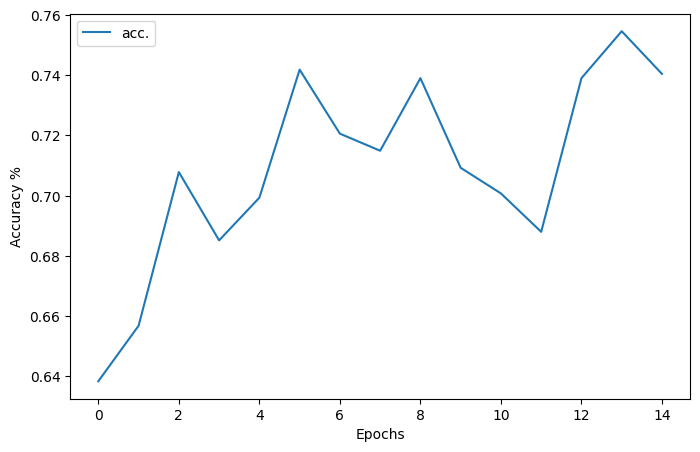

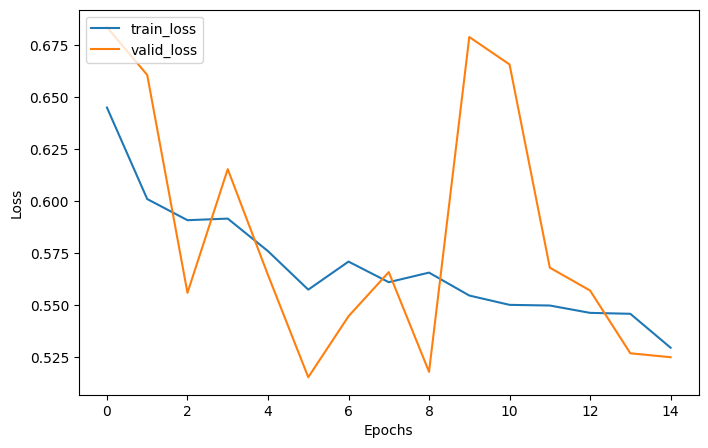

1 / 188 Loss =  tensor(0.4604, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.5994, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.4147, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.6516, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.7268, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4235, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.7221, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.6245, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4621, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.3760, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.5231, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.5960, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5023, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

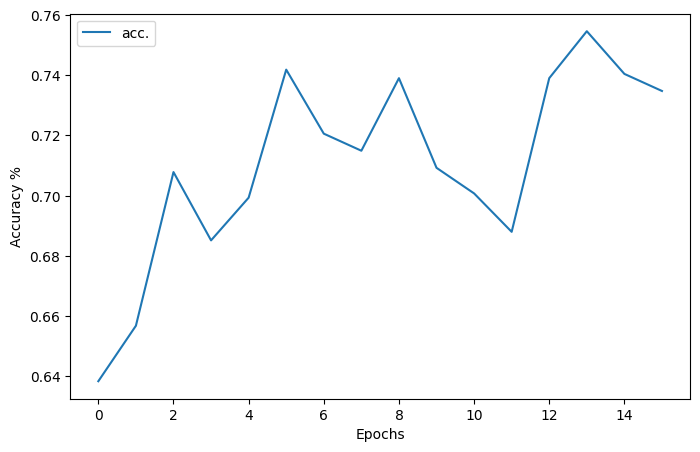

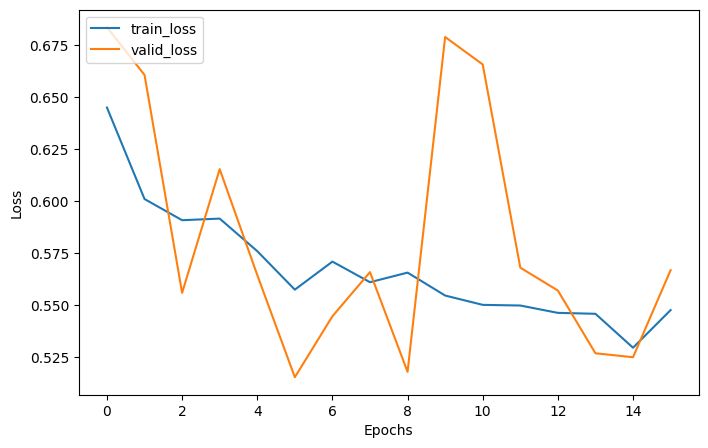

1 / 188 Loss =  tensor(0.5219, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.7760, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.7902, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.5393, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.4805, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.3541, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.8462, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.5420, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.5345, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.7078, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.4917, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.6719, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.6721, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

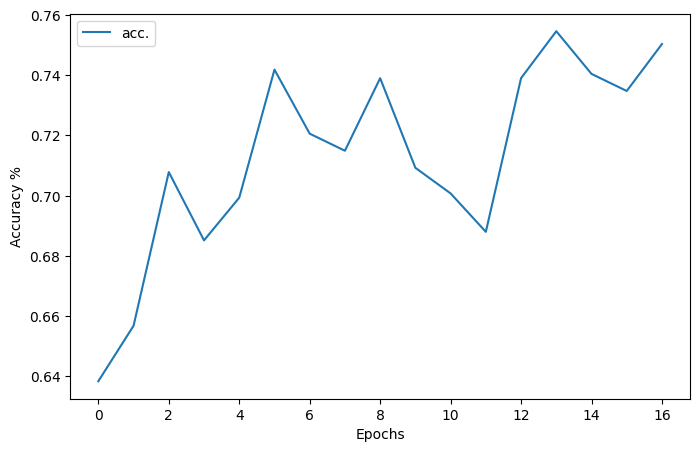

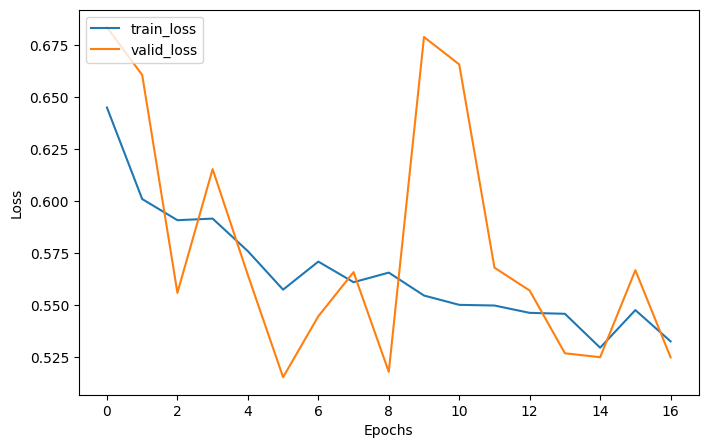

1 / 188 Loss =  tensor(0.9456, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.6597, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.4994, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.4480, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.5663, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.7137, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.3959, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.4744, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.7196, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.5308, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.4989, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.3625, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5214, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

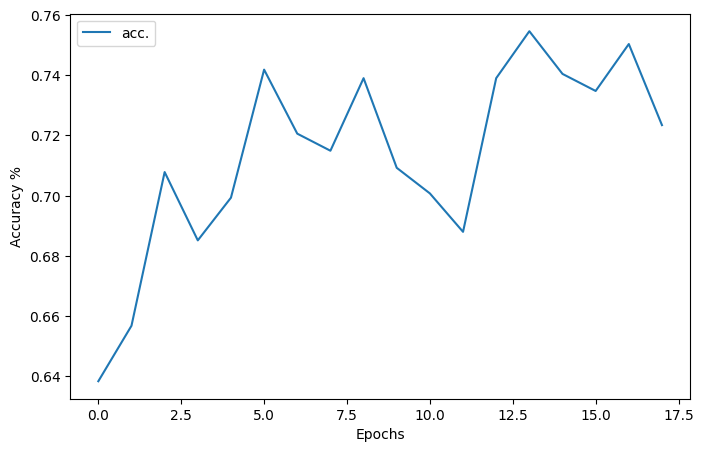

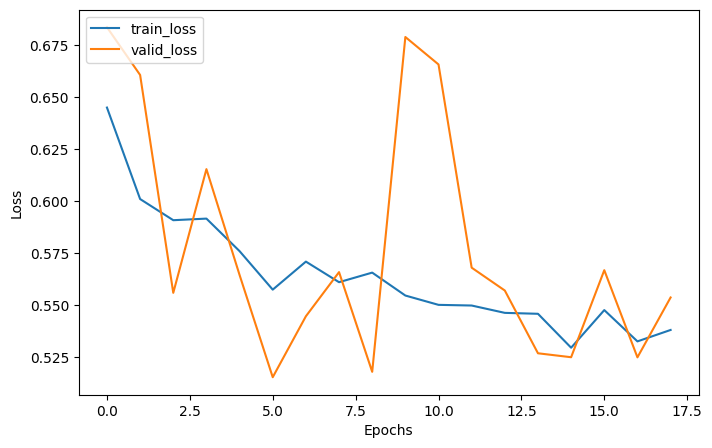

1 / 188 Loss =  tensor(0.8389, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4420, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.4062, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.7981, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.4980, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4890, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.4722, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.6856, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.5526, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4279, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.6425, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.5283, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5238, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

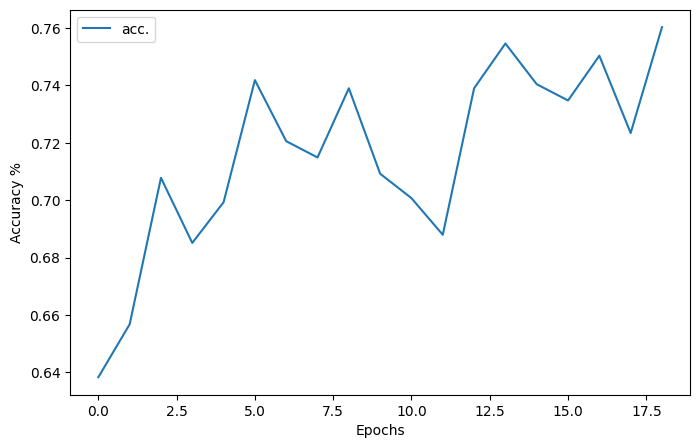

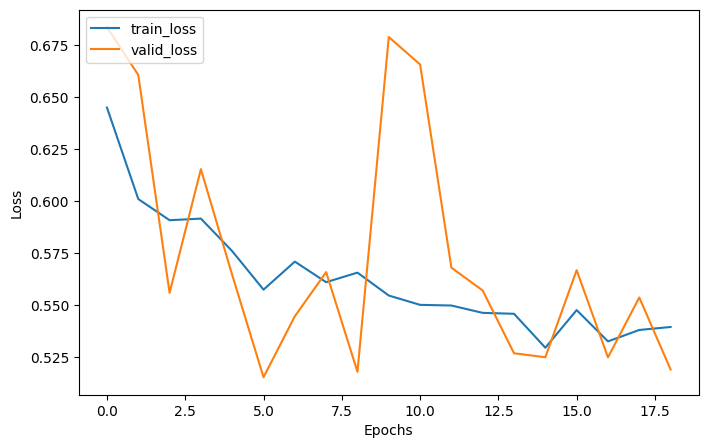

1 / 188 Loss =  tensor(0.6452, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4621, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.4534, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.5087, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.4859, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4470, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.8608, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.4206, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.5112, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4741, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.4121, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4435, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5316, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

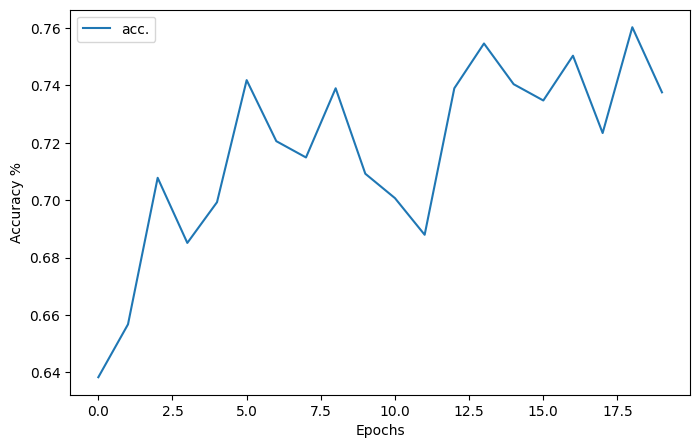

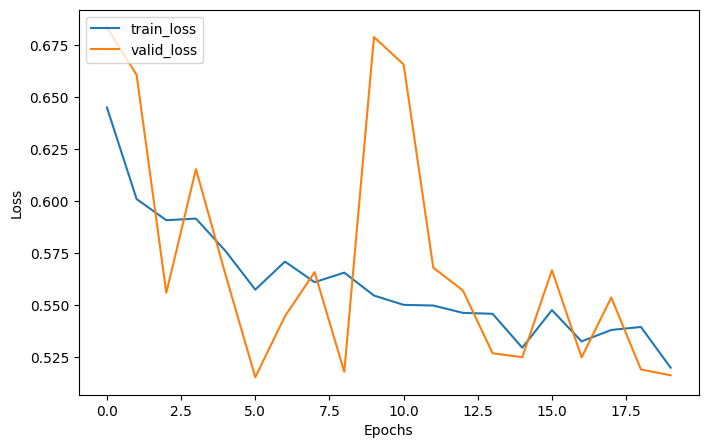

1 / 188 Loss =  tensor(0.4401, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4940, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.4105, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.6004, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.5744, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.3006, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.4143, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.4452, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.5084, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.5558, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.4983, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.5195, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5941, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

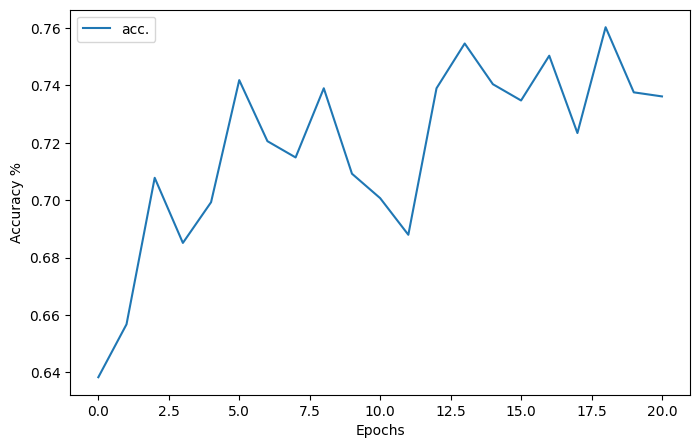

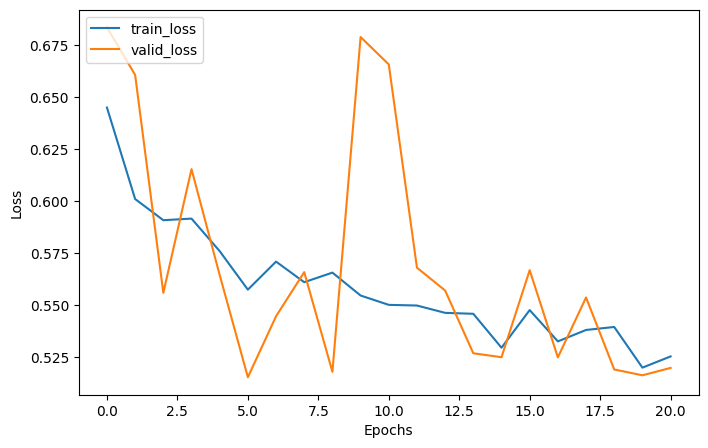

1 / 188 Loss =  tensor(0.5027, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4430, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.3962, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.5937, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.3475, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.5214, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.3344, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.7291, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.6825, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.5375, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.7380, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.3205, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5662, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

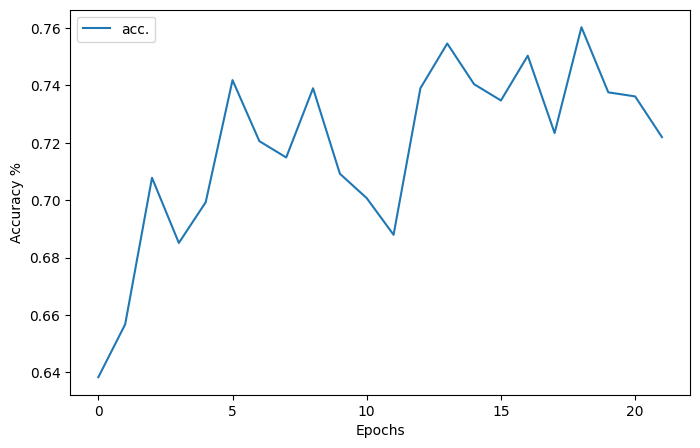

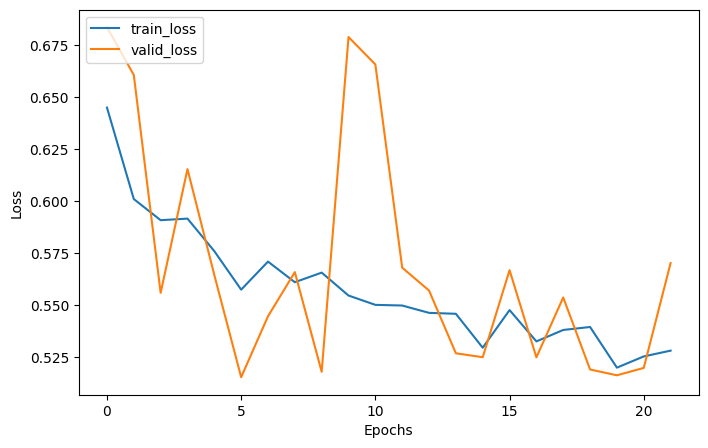

1 / 188 Loss =  tensor(0.3969, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4255, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.7584, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.6404, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.3550, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.5678, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.3524, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.6291, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4405, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.5165, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.6026, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.6025, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.4202, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

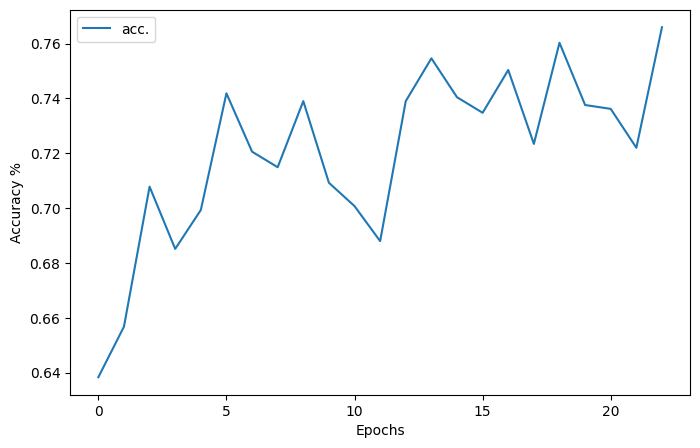

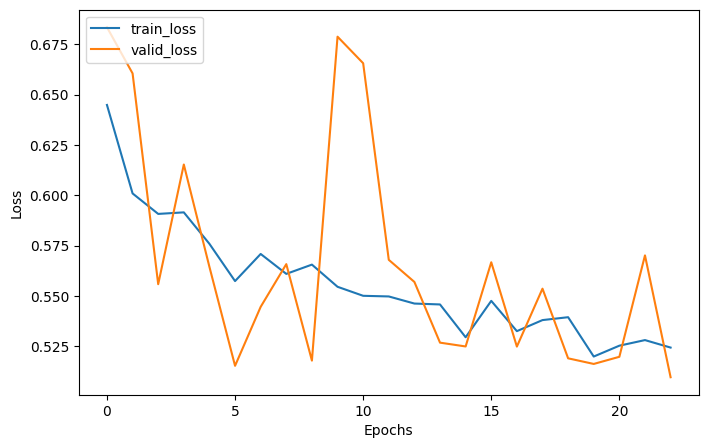

1 / 188 Loss =  tensor(0.5519, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.5986, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.7868, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.4795, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.5191, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.3125, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.6643, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.4277, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4846, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.3697, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.3830, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4429, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.4256, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

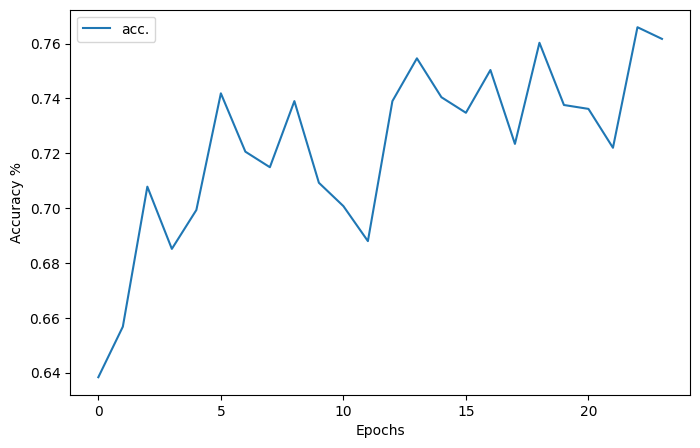

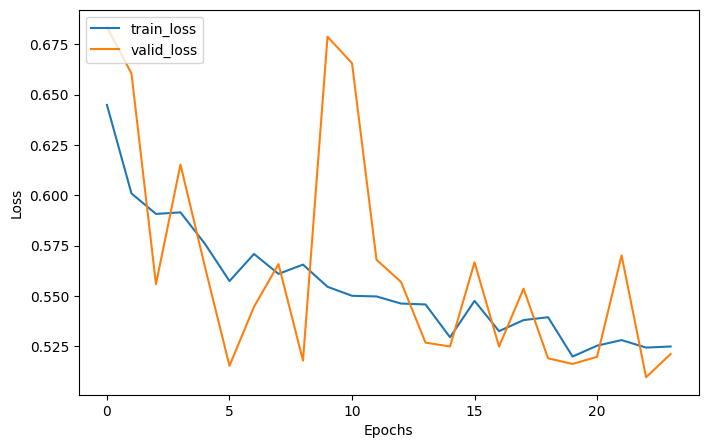

1 / 188 Loss =  tensor(0.3823, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4243, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.5578, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.3963, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.6208, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.3016, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.4550, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.7180, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4238, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.3854, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.5054, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4910, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.6568, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

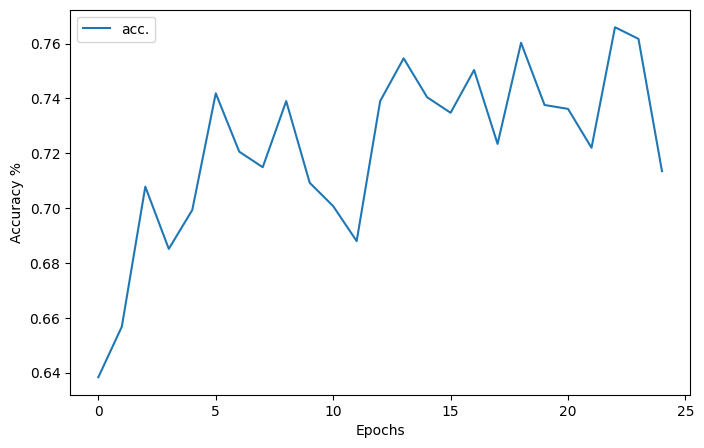

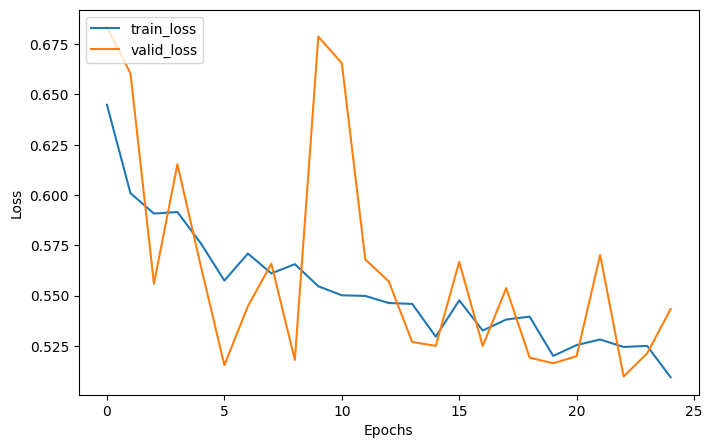

1 / 188 Loss =  tensor(0.7153, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4450, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.5602, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.3810, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.4022, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4920, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.4498, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.3776, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4819, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4010, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.6451, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.5582, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.9268, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

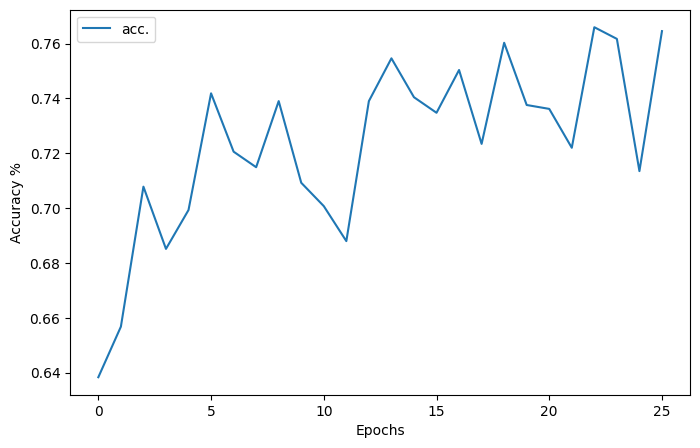

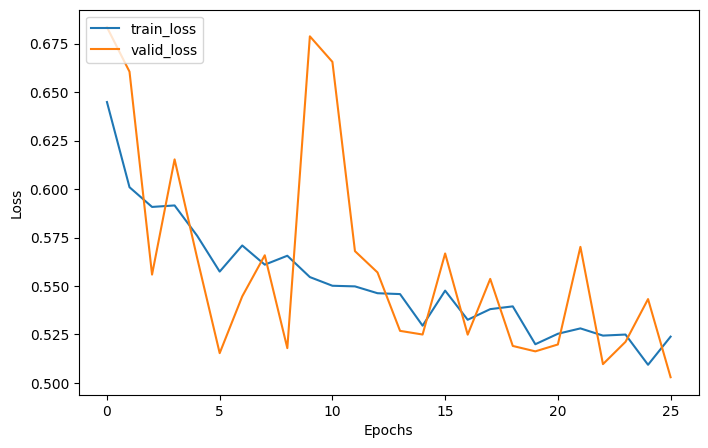

1 / 188 Loss =  tensor(0.4325, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4915, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.5228, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.5906, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.6152, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4184, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.4790, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.3873, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.7493, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.3999, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.5702, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.2971, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.8270, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

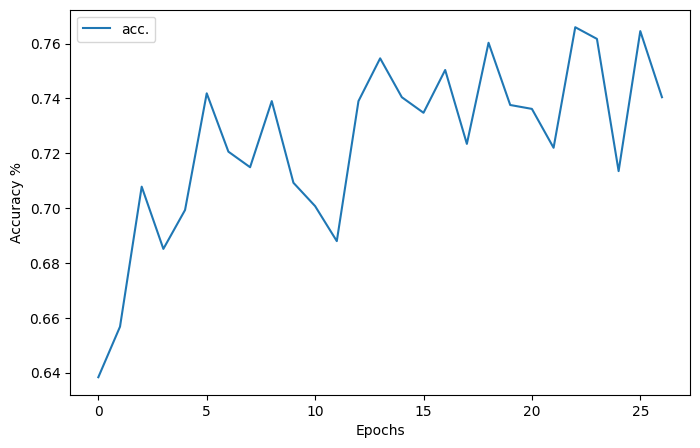

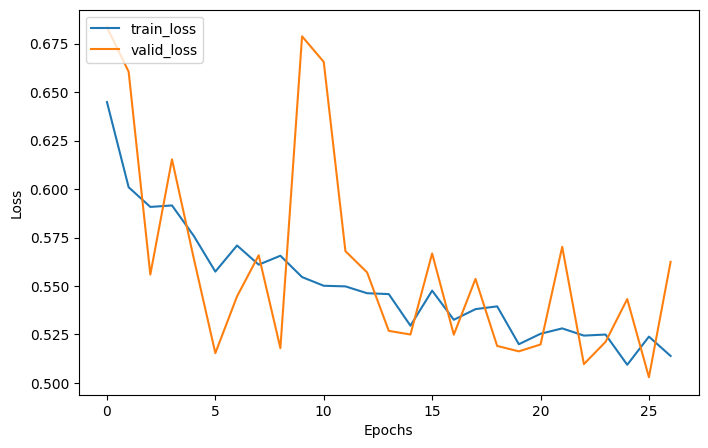

1 / 188 Loss =  tensor(0.3471, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.3559, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.5306, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.6231, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.5331, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4979, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.4437, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.4655, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.5284, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.3599, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.7298, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4436, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.4605, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

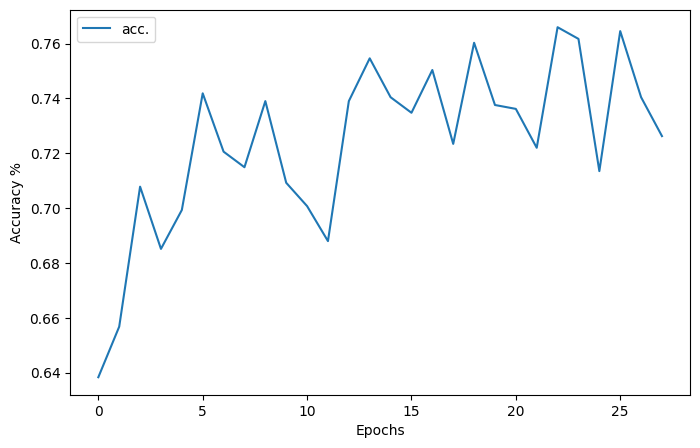

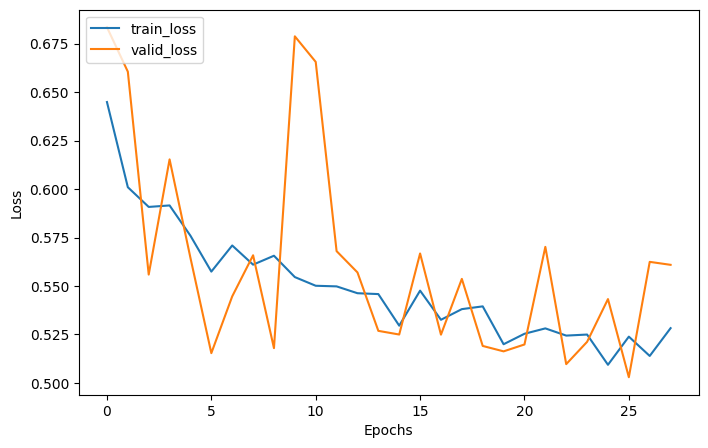

1 / 188 Loss =  tensor(0.3741, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.3571, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.5579, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.6271, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.7766, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4329, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.4653, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.5225, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.7810, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.6285, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.4448, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.3842, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5253, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

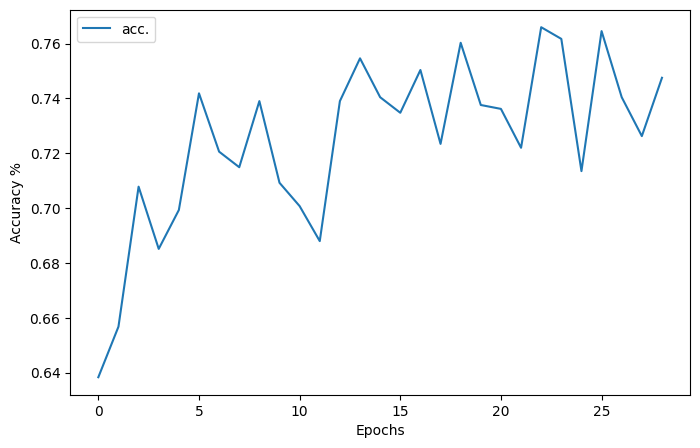

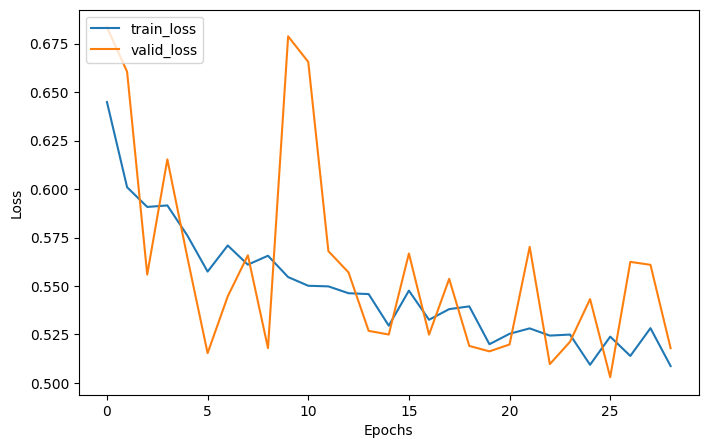

1 / 188 Loss =  tensor(0.6055, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4823, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.3206, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.4550, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.4526, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.3538, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.4700, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.5362, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.5257, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.6132, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.5085, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.5393, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5212, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

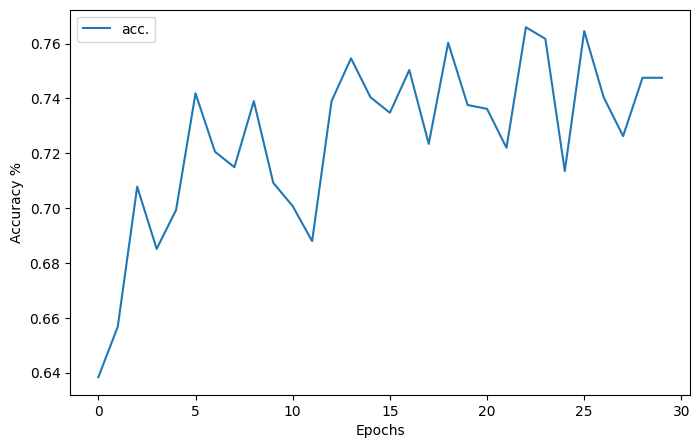

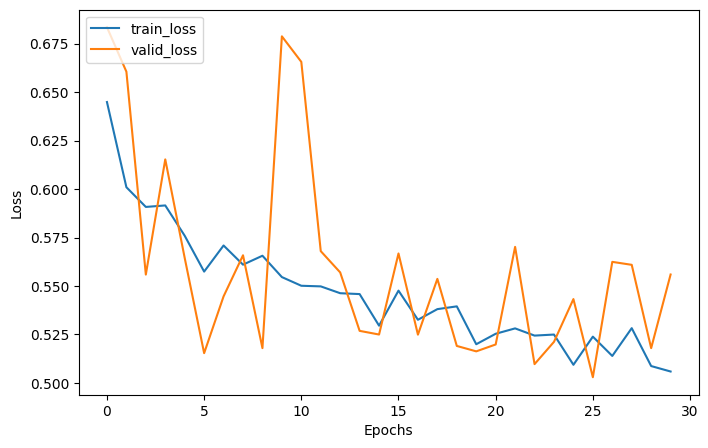

1 / 188 Loss =  tensor(0.4487, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4114, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.5613, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.5050, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.3916, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.5325, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.3473, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.6254, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4348, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.6306, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.3669, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4284, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.7603, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

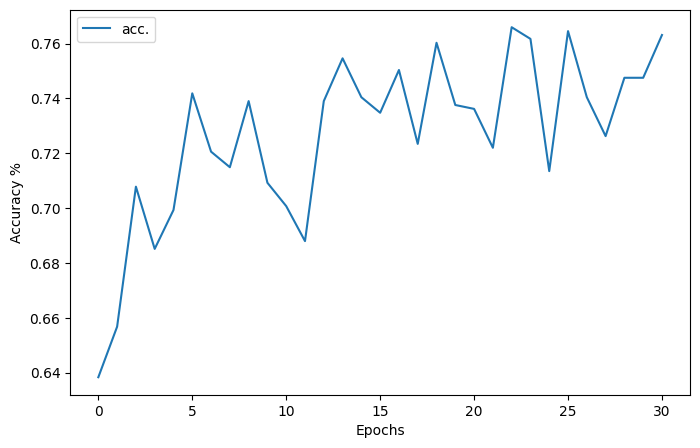

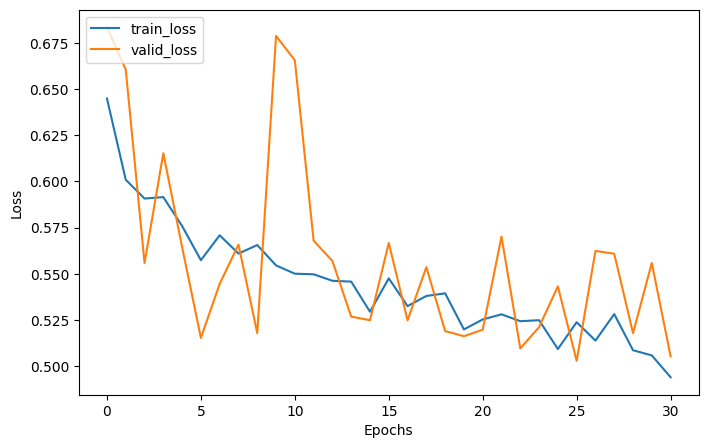

1 / 188 Loss =  tensor(0.5152, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.5719, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.5087, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.7760, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.5391, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4638, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.4547, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.4885, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.3798, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4283, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.5355, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4339, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.4000, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

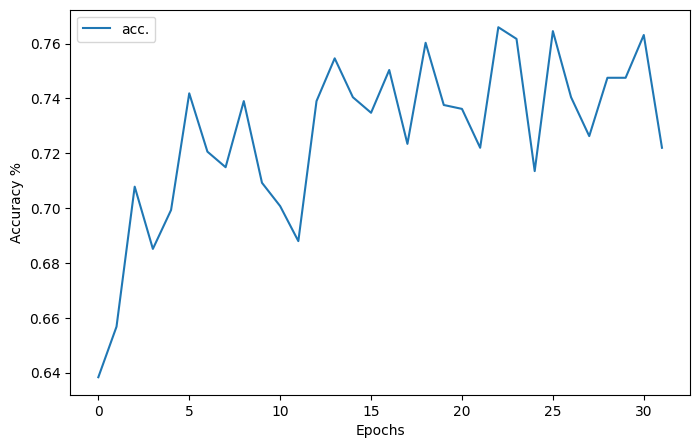

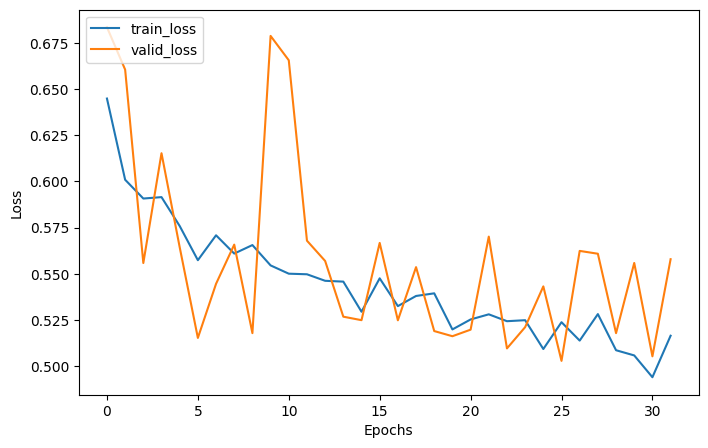

1 / 188 Loss =  tensor(0.2661, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4444, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.8411, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.4576, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.3921, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.6366, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.3517, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.3819, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4499, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.7956, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.7587, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4873, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.4979, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

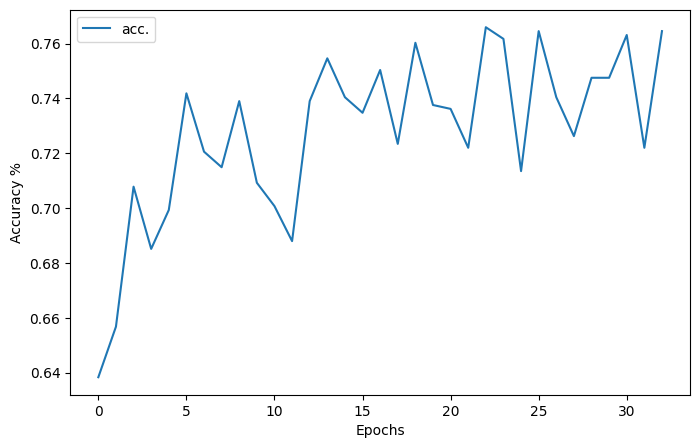

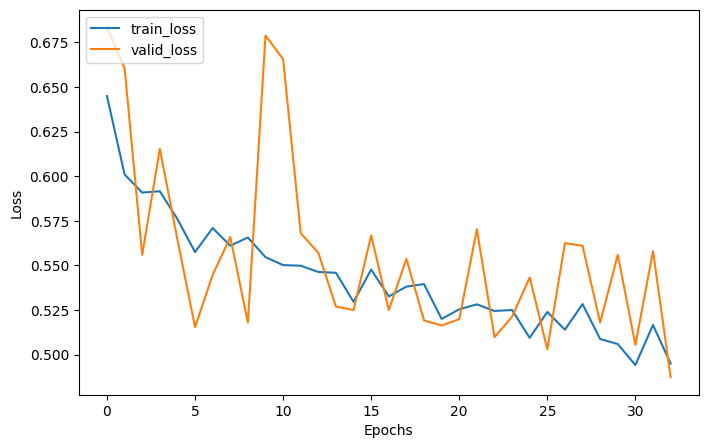

1 / 188 Loss =  tensor(0.6569, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.3372, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.4783, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.3307, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.2856, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.3151, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.3874, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.3378, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.5501, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.5188, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.3249, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.2537, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.3989, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

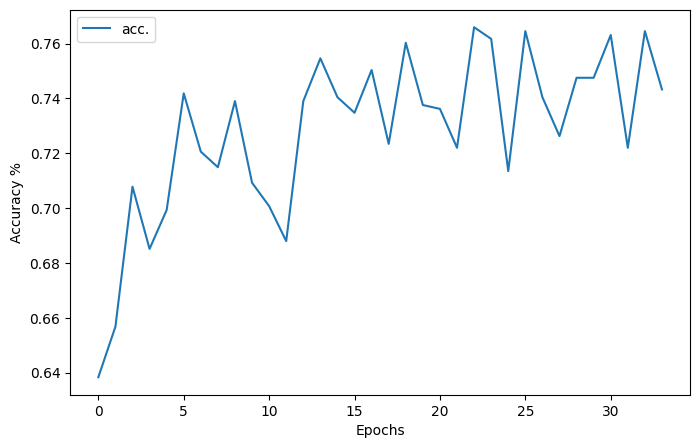

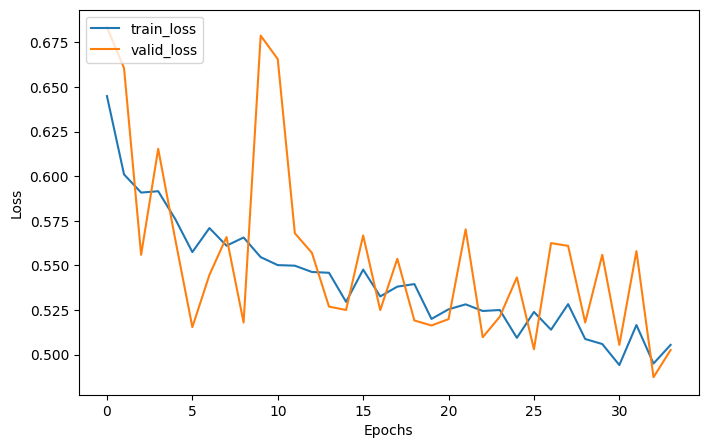

1 / 188 Loss =  tensor(0.4461, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4994, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.5322, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.6165, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.4724, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4382, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.5656, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.5503, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.5966, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.3930, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.6223, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4575, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.6493, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

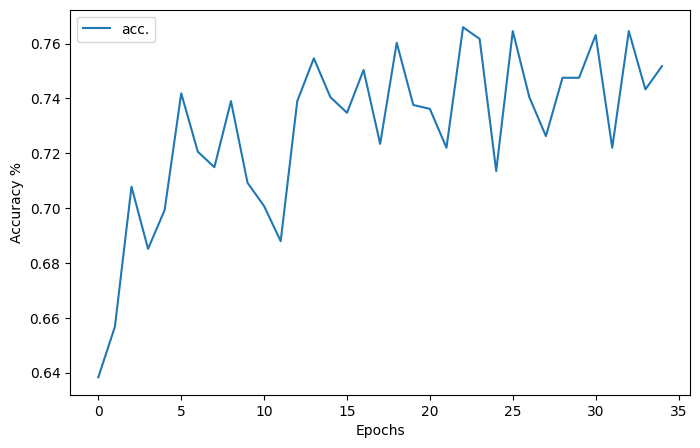

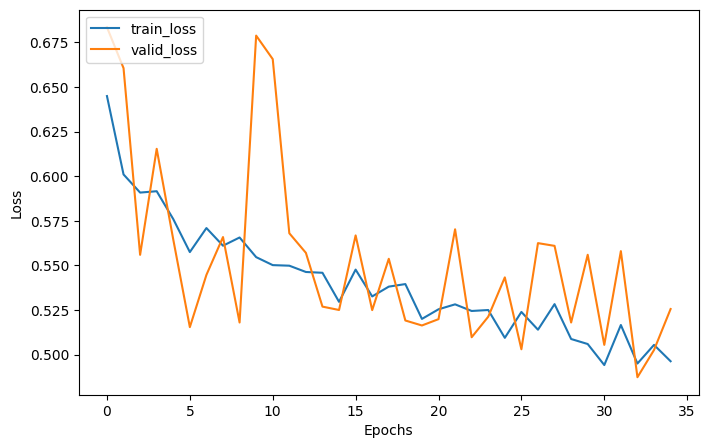

1 / 188 Loss =  tensor(0.3609, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.8095, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.6556, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(1.2180, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.4891, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.3861, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.2949, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.4025, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4710, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.3077, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.5817, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4198, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5936, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

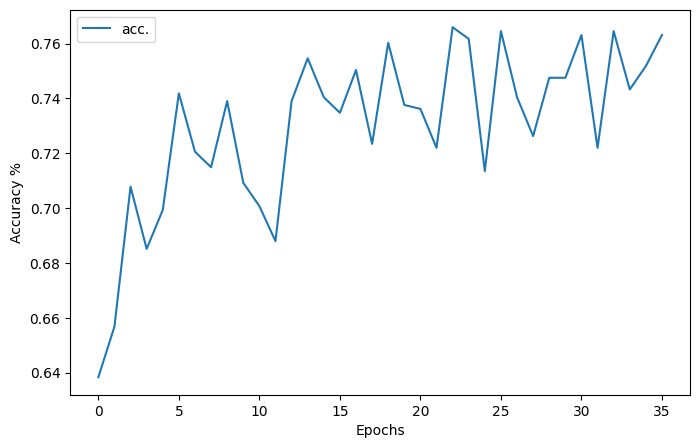

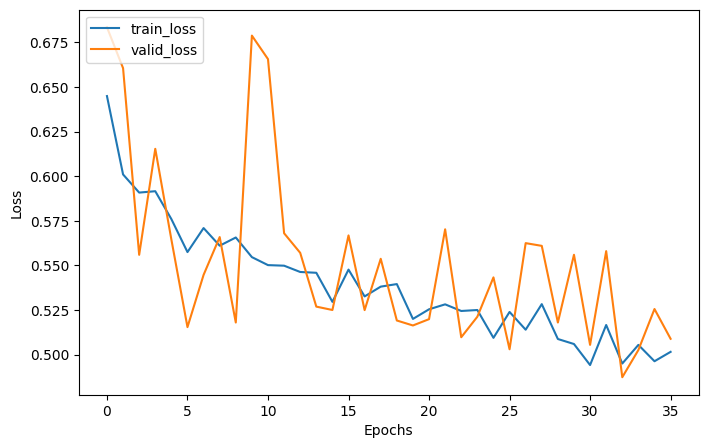

1 / 188 Loss =  tensor(0.3957, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.3056, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.3376, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.4984, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.4583, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.7100, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.4465, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.3733, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4422, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4509, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.4978, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.5096, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.3950, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

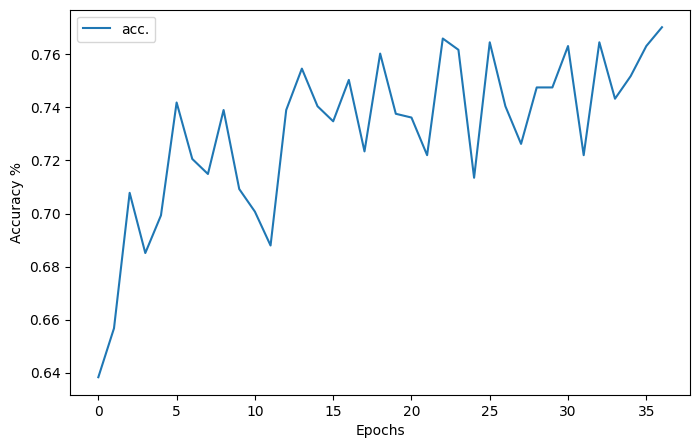

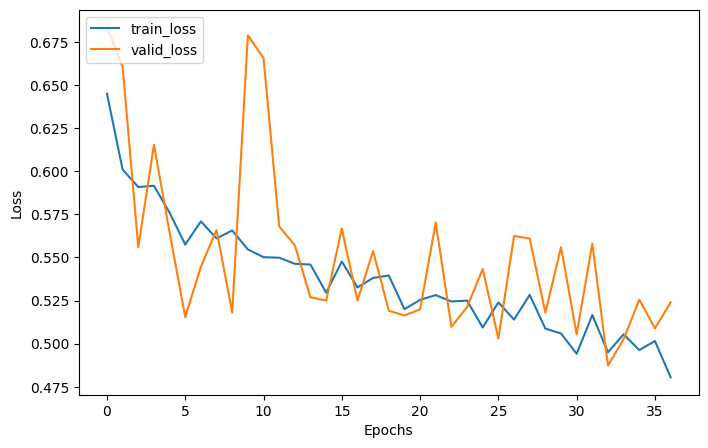

1 / 188 Loss =  tensor(0.3397, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4364, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.5403, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.7265, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.5737, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.5458, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.3995, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.6757, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4382, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4711, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.5712, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.5842, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5676, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

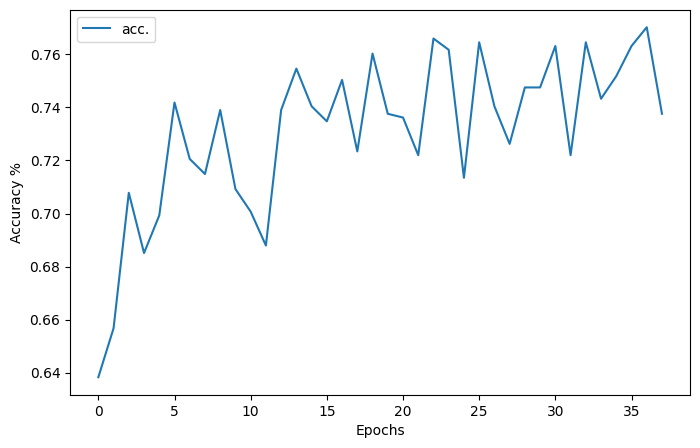

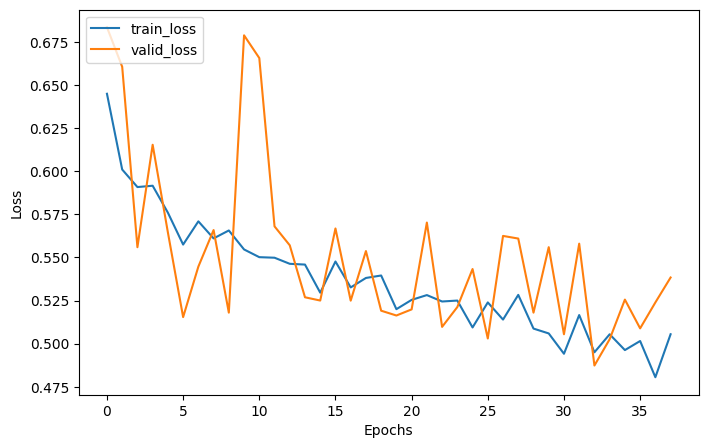

1 / 188 Loss =  tensor(0.4644, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.6832, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.5321, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.3915, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.5347, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4495, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.8074, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.6672, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.6013, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.5411, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.6139, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.3957, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.3703, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

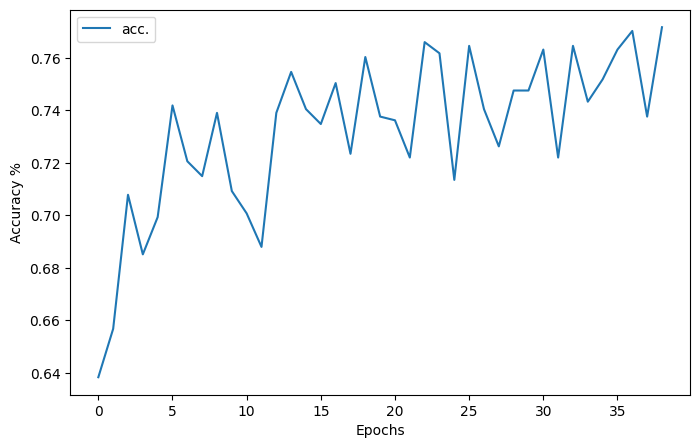

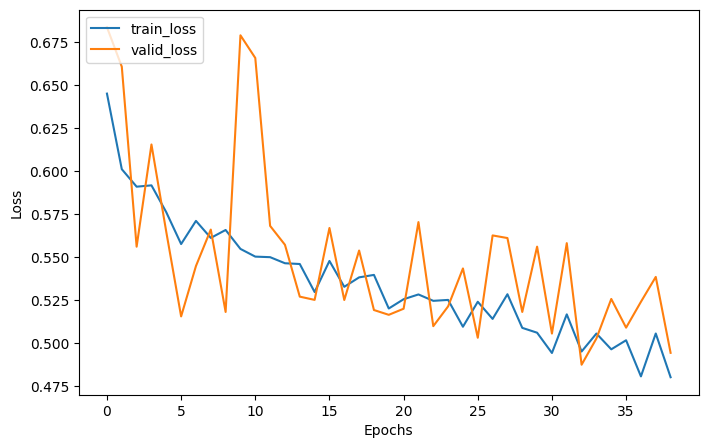

1 / 188 Loss =  tensor(0.4576, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.5611, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.2788, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.5027, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.7280, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4236, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.5652, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.5272, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4697, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.2797, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.3961, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.6349, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5590, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

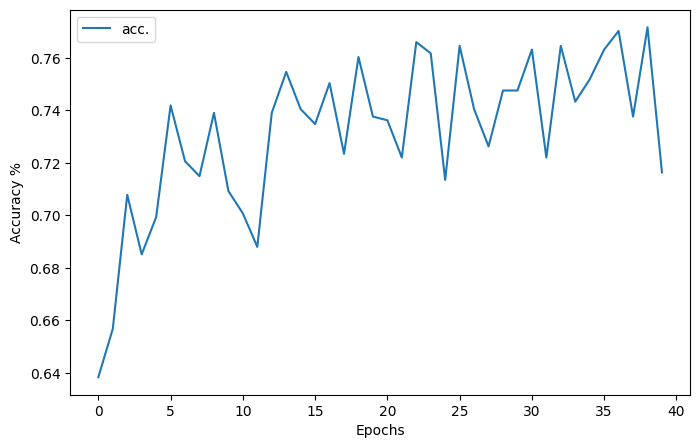

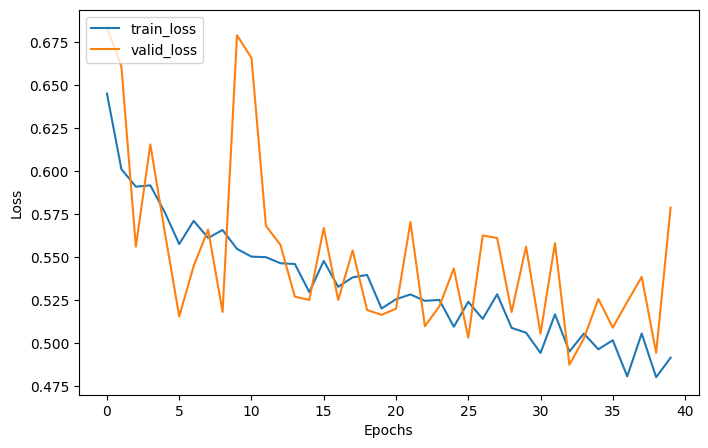

1 / 188 Loss =  tensor(0.4951, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.3730, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.3735, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.3096, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.4666, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.3485, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.7303, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.5267, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.3378, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4296, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.2948, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4456, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5962, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

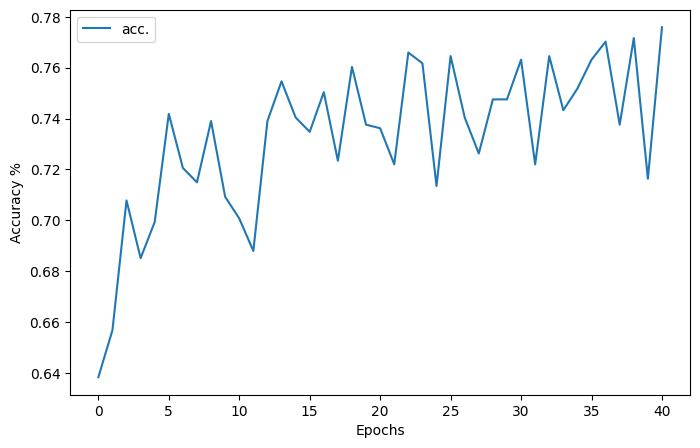

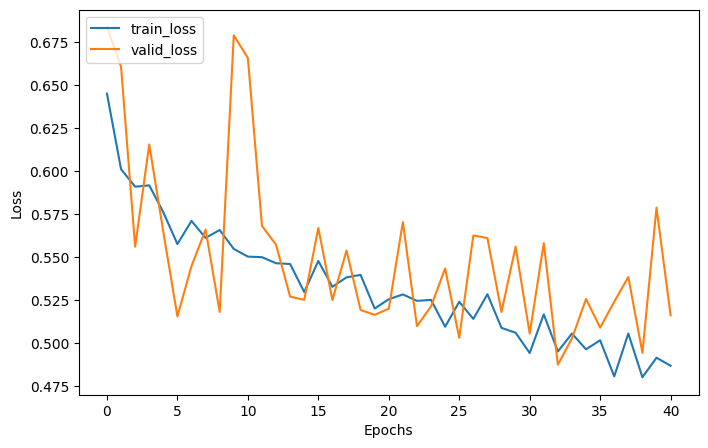

1 / 188 Loss =  tensor(0.3351, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4879, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.4831, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.3400, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.3353, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4810, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.4777, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.7371, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.5594, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.3790, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.4844, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.2282, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5353, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

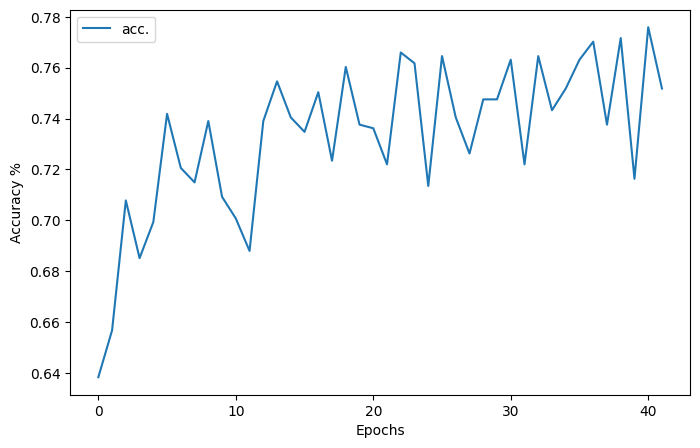

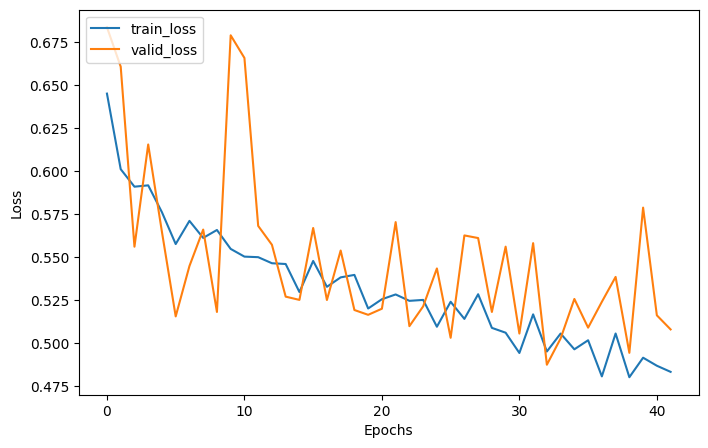

1 / 188 Loss =  tensor(0.6161, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.5093, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.5162, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.5629, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.6691, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.6159, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.5445, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.2984, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4029, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.6110, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.6828, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4573, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5374, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

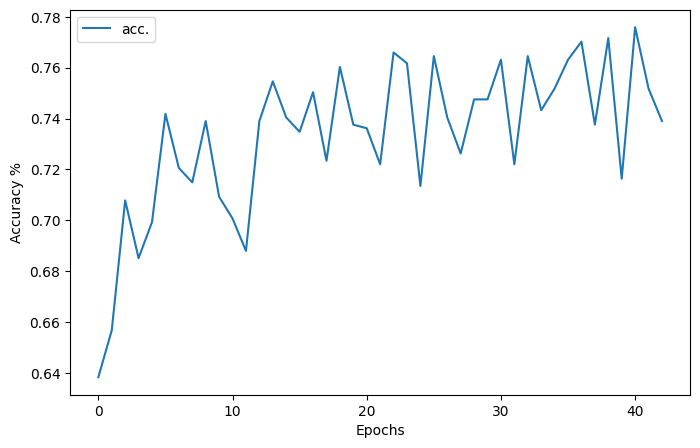

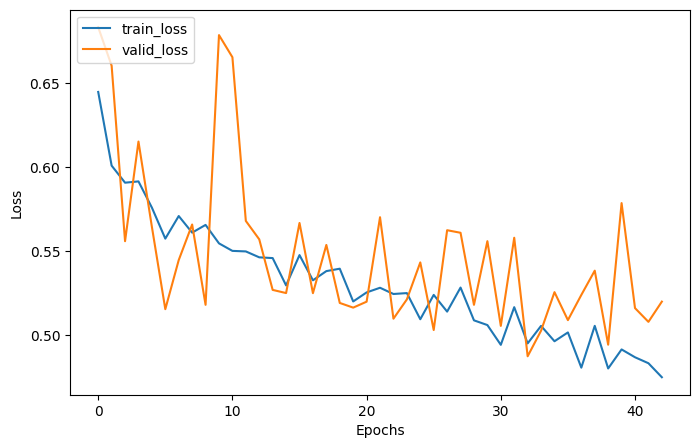

1 / 188 Loss =  tensor(0.3358, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4653, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.5844, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.3743, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.7076, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.3469, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.5704, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.5376, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4558, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4789, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.5565, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.6921, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.4407, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

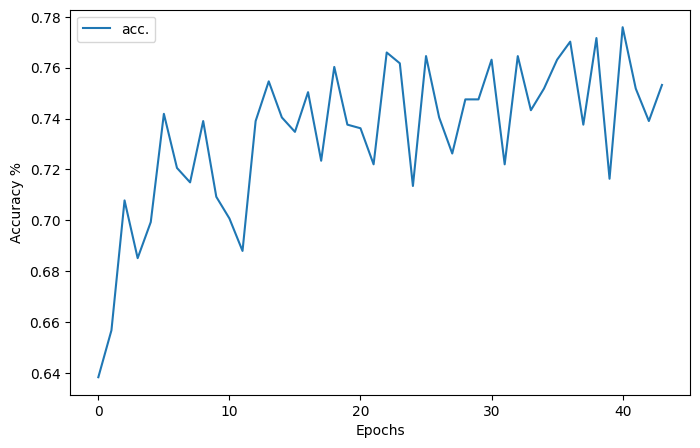

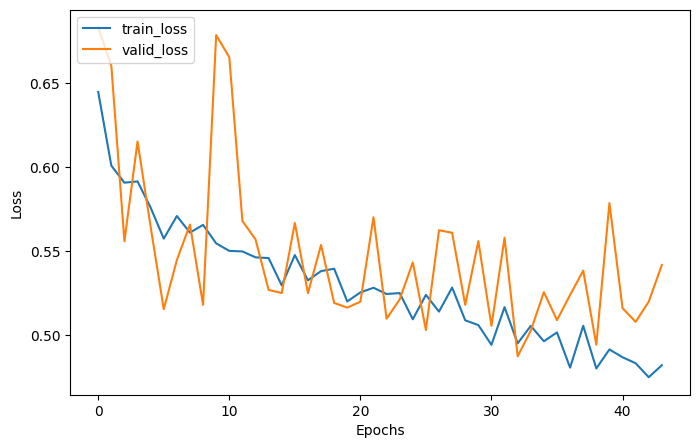

1 / 188 Loss =  tensor(0.2527, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4673, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.3866, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.4532, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.4953, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4432, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.5536, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.6737, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.5122, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4288, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.3635, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4187, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.4209, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

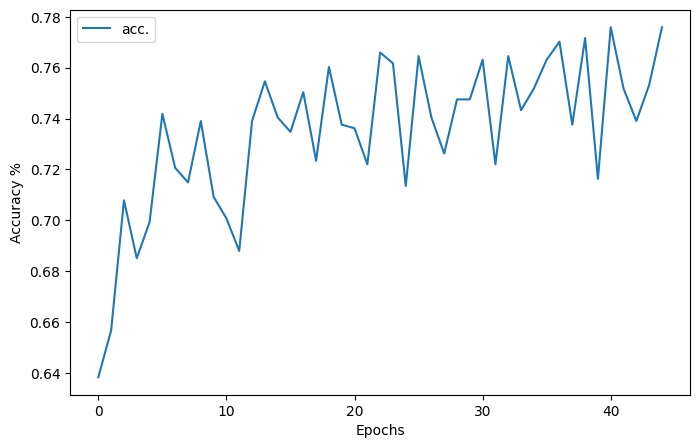

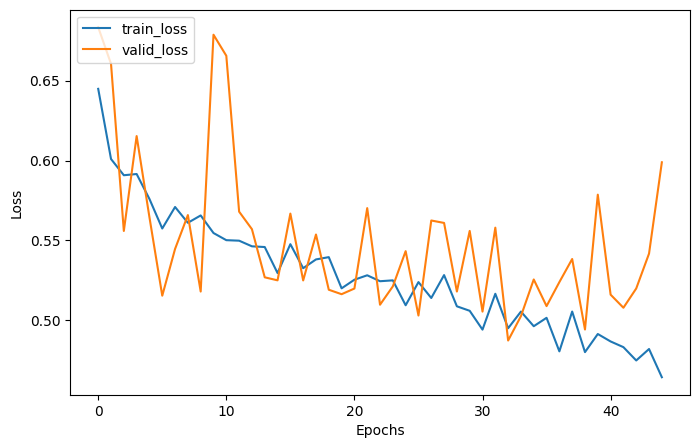

1 / 188 Loss =  tensor(0.9420, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.2834, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.6892, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.3370, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.2215, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4081, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.6371, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.4311, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.5330, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.3574, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.3683, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4408, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5287, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

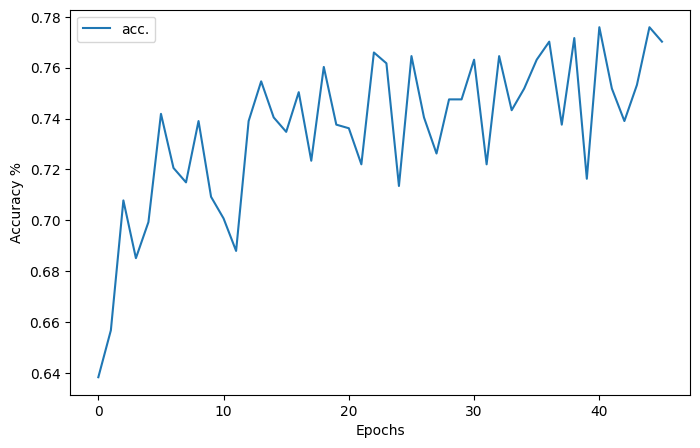

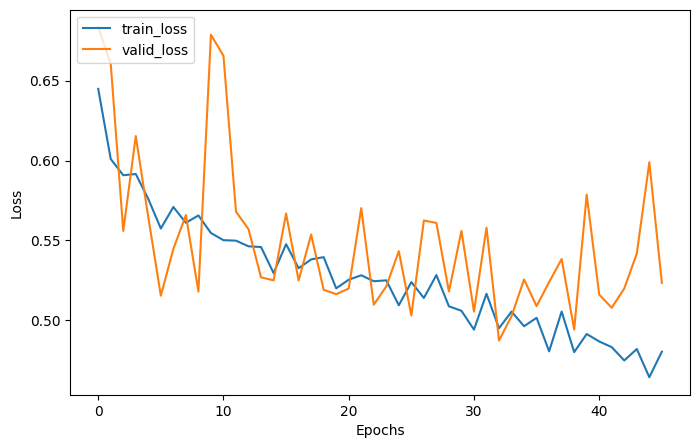

1 / 188 Loss =  tensor(0.3535, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4165, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.3985, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.4516, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.4882, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.5342, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.5027, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.6620, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.5571, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.5396, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.4156, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4365, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.4588, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

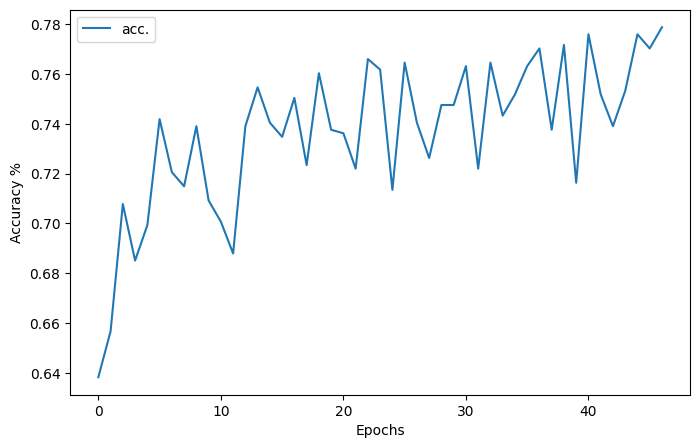

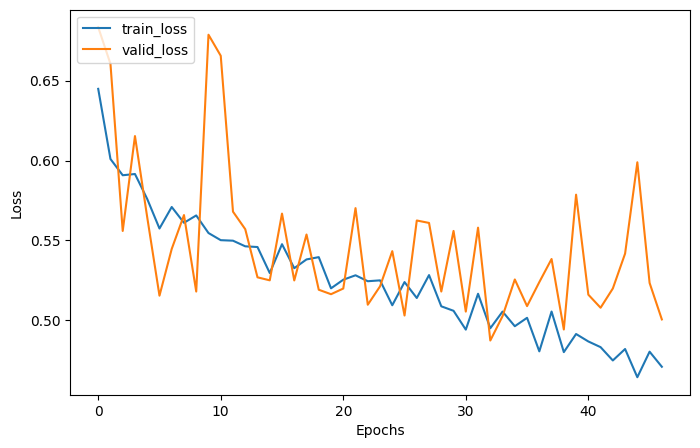

1 / 188 Loss =  tensor(0.4625, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.7585, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.4143, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.5381, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.5237, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.5170, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.5702, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.4087, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.5090, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.5053, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.4099, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4381, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.5573, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

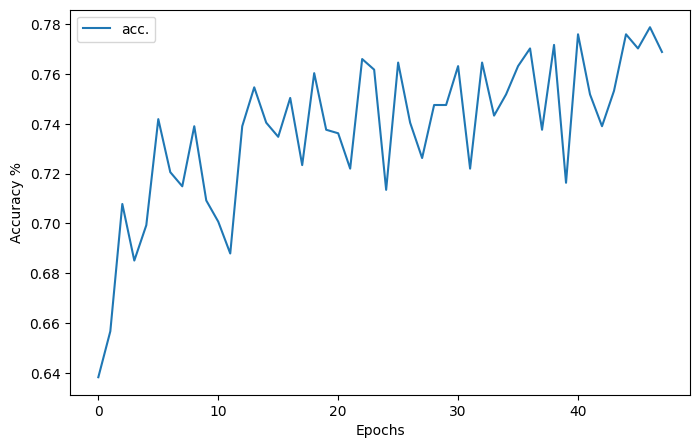

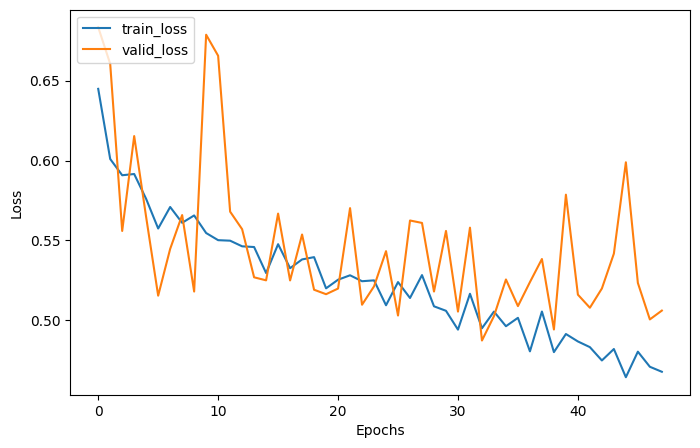

1 / 188 Loss =  tensor(0.8299, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.5325, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.2734, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.6365, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.3565, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4124, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.6996, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.6575, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.3839, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4290, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.3694, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.4834, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.7912, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

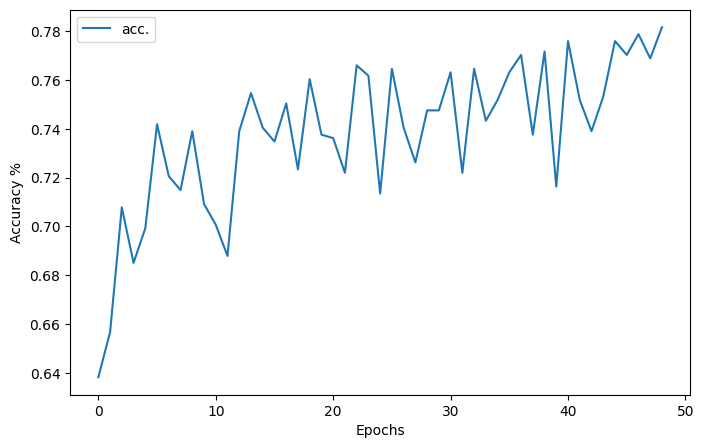

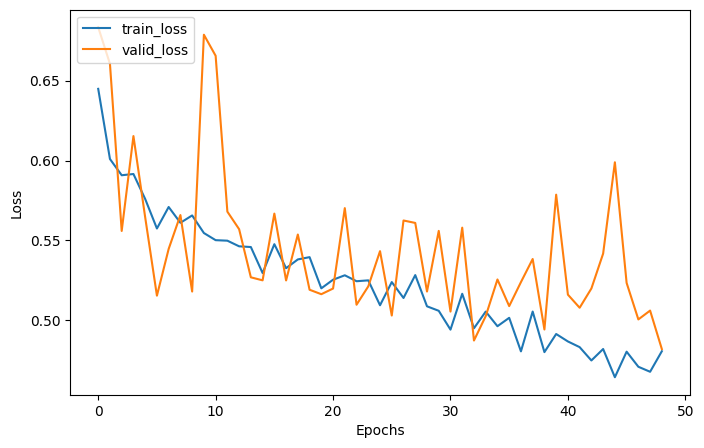

1 / 188 Loss =  tensor(0.4982, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 188 Loss =  tensor(0.4581, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 188 Loss =  tensor(0.2498, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 188 Loss =  tensor(0.4828, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 188 Loss =  tensor(0.4486, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 188 Loss =  tensor(0.4256, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 188 Loss =  tensor(0.3895, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 188 Loss =  tensor(0.5092, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 188 Loss =  tensor(0.4018, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 188 Loss =  tensor(0.4795, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 188 Loss =  tensor(0.4070, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 188 Loss =  tensor(0.2763, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 188 Loss =  tensor(0.2176, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 188

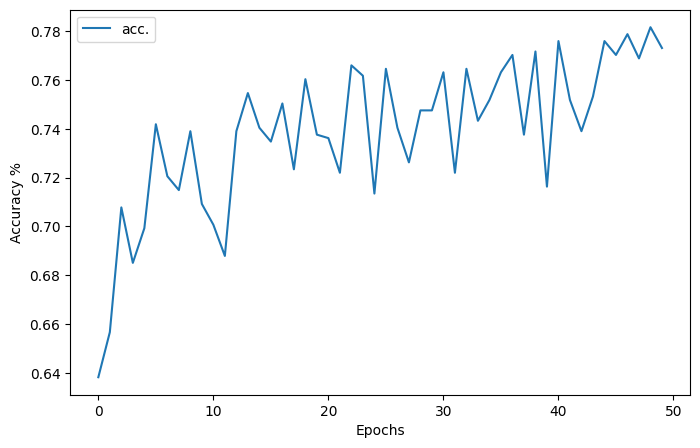

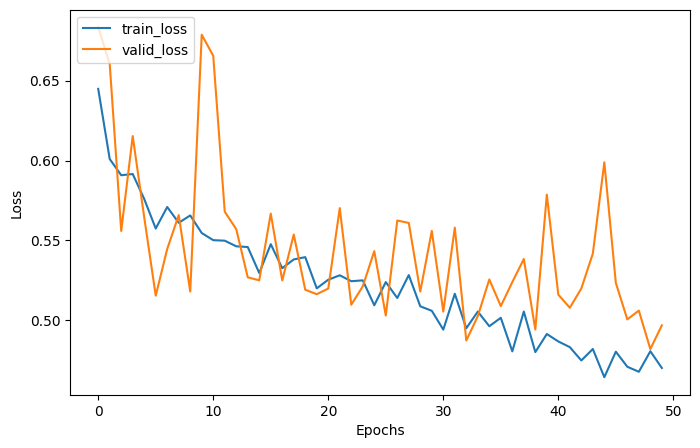

In [14]:
import matplotlib.pyplot as plt
#training
epochs = 50
best_valid_loss = 10
best_epoch = 0

train_loss_list = []
valid_loss_list = []
accuracy_list = []

for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    accuracy = 0
    
    # Training the model
    model.train()
    counter = 0
    for inputs, labels in train_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.type(torch.ByteTensor).to(device)
        # Clear optimizers
        optimizer.zero_grad()
        # Forward pass
        output = model.forward(inputs)
        # Loss
        '''print(output,labels)'''
        loss = criterion(output, labels)
        # Calculate gradients (backpropogation)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        # Add the loss to the training set's rnning loss
        train_loss += loss.item()*inputs.size(0)
        
        # Print the progress of our training
        counter += 1
        print(counter, "/", len(train_loader), "Loss = ", loss)
        
    # Evaluating the model
    model.eval()
    counter = 0
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move to device
            inputs, labels = inputs.to(device), labels.type(torch.ByteTensor).to(device)
            # Forward pass
            output = model.forward(inputs)
            # Calculate Loss
            valloss = criterion(output, labels)
            # Add loss to the validation set's running loss
            val_loss += valloss.item()*inputs.size(0)
            
            # Since our model outputs a LogSoftmax, find the real 
            # percentages by reversing the log function
            output = torch.exp(output)
            # Get the top class of the output
            top_p, top_class = output.topk(1, dim=1)
            # See how many of the classes were correct?
            equals = top_class == labels.view(*top_class.shape)
            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Print the progress of our evaluation
            counter += 1
            print(counter, "/", len(val_loader), "Accuracy = ", accuracy)
    
    # Get the average loss for the entire epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(val_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    accuracy_list.append(accuracy/len(val_loader))
    if (valid_loss<best_valid_loss):
      best_valid_loss = valid_loss
      best_epoch = epoch
      #torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/checkpoint.pth')
      print('The saved model is the {} epoch'.format(epoch))
    # Print out the information
    print('Accuracy: ', accuracy/len(val_loader))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    print('Best epoch is {}'.format(best_epoch))
    
    

    plt.figure(figsize=(8, 5))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy %")

    plt.plot(accuracy_list, label = "acc.")
    plt.legend(loc=2)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.plot(train_loss_list, label = "train_loss")
    plt.plot(valid_loss_list, label = "valid_loss")
    plt.legend(loc=2)
    plt.show()

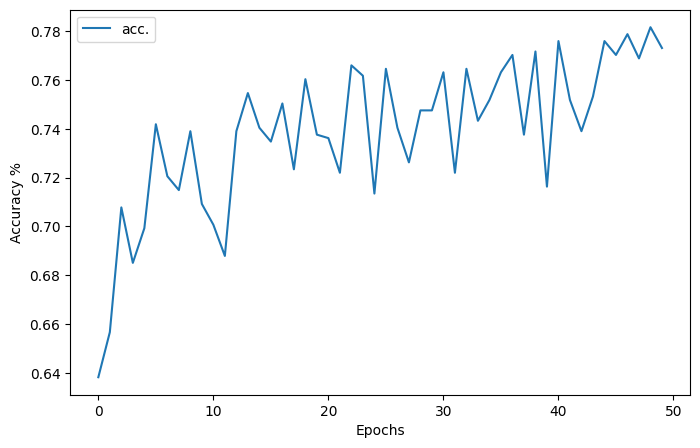

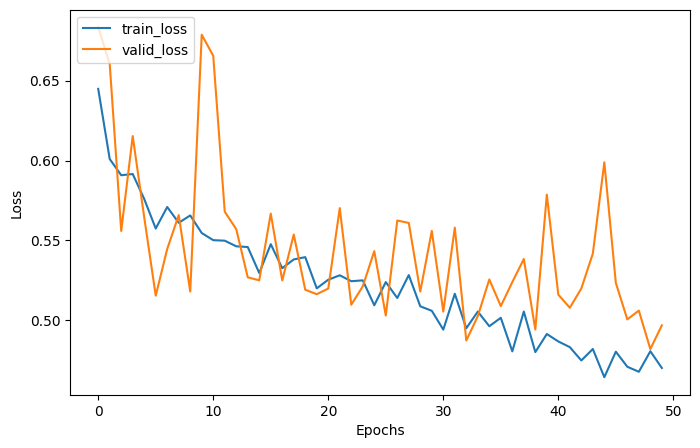

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")

plt.plot(accuracy_list, label = "acc.")
plt.legend(loc=2)
plt.show()

plt.figure(figsize=(8, 5))
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot(train_loss_list, label = "train_loss")
plt.plot(valid_loss_list, label = "valid_loss")
plt.legend(loc=2)
plt.show()